In [4]:
import os
ROOT = "/content/drive/MyDrive/NLP/CRM"
os.chdir(ROOT)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install wordsegment
# !pip install textblob
# !pip install contractions
#!pip install pyLDAvis

In [1]:
import pandas as pd
import pickle
import nltk
import re
import string
from wordsegment import load, segment
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import contractions
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#vis
import pyLDAvis
import pyLDAvis.gensim_models

#spacy
import spacy


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from sklearn.model_selection import GridSearchCV


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,classification_report

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.ensemble import RandomForestClassifier

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Cleaning

In [89]:
leads = pd.read_excel("1000_leads.xlsx")
leads = leads[leads.filter(regex='^(?!Unnamed)').columns]

In [41]:
leads.head(100)

Lead Name   Location        Status   \
0                  Raja  hyderabad  Not Converted   
1         Anirudh Reddy       pune  Not Converted   
2          Sapna Dewani  bangalore     Converted    
3                suresh     mumbai  Not Converted   
4         Akshay Shinde  hyderabad  Not Converted   
..                  ...        ...            ...   
95               Murali  bangalore  Not Converted   
96  Priya Krishnamurthy  hyderabad     Converted    
97                wajid  hyderabad  Not Converted   
98               KHADER  bangalore  Not Converted   
99                Ranga  hyderabad     Converted    

                                   Status information  
0   14/8/prema: share me details, available in evn...  
1   14/8/prema: cal me tmrw, shared details to ema...  
2                                    16|AuG|moHan:rnr  
3   14/8/17(Surendra):i want only Server 16|AuG|mo...  
4   14/8/prema:rnr 16/8/prema: gave info, he said ...  
..                                                ...  
95  4/8/17(Surendra):RNR 4/8/17(Surendra):call me ...  
96  4/8/17(soma):RNR,Details Shared 8/8/17(soma):w...  
97  4/8/prema: share me details, u can call me tmr...  
98  4/8/PREMA: rnr 9/8/prema: share me details, to...  
99                                         alrady reg  

[100 rows x 4 columns]

In [99]:
leads = leads.rename(columns=lambda x: x.strip())

In [8]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 0 to 1000
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Lead Name           956 non-null    object
 1   Location            956 non-null    object
 2   Status              956 non-null    object
 3   Status information  956 non-null    object
 4   cleaned_text        956 non-null    object
dtypes: object(5)
memory usage: 44.8+ KB


In [ ]:
leads.dropna(axis=0,inplace=True)

In [9]:
leads.shape

(956, 5)

In [100]:
leads['Location'] = leads['Location'].apply(str.lower)
leads['Location'] = leads['Location'].apply(lambda x: x.strip())
leads['Status'] = leads['Status'].apply(str.lower)
leads['Status'] = leads['Status'].apply(lambda x: x.strip())
leads['Status'] = leads['Status'].replace('conveted','converted')
leads['Status'] = leads['Status'].replace('converted',1)
leads['Status'] = leads['Status'].replace('Not Converted',0)

In [12]:
leads['Status information'][750]

'23/MaY/moHan:attnde demo 23/MaY/moHan:he want in june today check and will make token payment 30/MaY/moHan:he will research and do token payment 7/JunE/moHan:he will check tmng nd respnd in 5dys 13/JunE/moHan:buay with work some othr time 13/JulY/moHan: call me mndy 2|AuG|moHan:i will try'

#Data cleaning considerations

Data normalization

1. remove data and name of the user,11/8/prema:, 10/8/17(Surendra):, 9|aUg|moHan:,31/5/17(gowtham)
2. spelling corrections
3. expand short forms like, n/w,banglr,discus,othr,intrstd,mrg,cal,tmrw, cert, n, reg, 1hr, 23rd , @5pm , ofc, 6:30 AM, amt,hav,wil,b e,'ssbb', 'ssgb', etc
4. constructions : i'm, don't,
5. RNR = ringing no response,CT = classroom training
6. Spelling corrections
7. Remove empty rows
8. replace numbers with words


In [39]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Lead Name           1001 non-null   object 
 1   Location            980 non-null    object 
 2   Status              998 non-null    object 
 3   Status information  977 non-null    object 
 4   Unnamed: 4          0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 39.2+ KB


#Deleting NaN rows

In [90]:
leads.dropna(axis=0,inplace=True)

In [44]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 0 to 1000
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Lead Name           956 non-null    object
 1   Location            956 non-null    object
 2   Status              956 non-null    object
 3   Status information  956 non-null    object
dtypes: object(4)
memory usage: 37.3+ KB


In [2]:
tech = ['tf','ios','iot','itil','java','mba',"mongo","ms",'msc','oracle','phd','pmp','qa','qc',"rprograming",'python','tableau','sas',"spark",'sql','tensorflow','excelr']


In [3]:
def lower_casing_text(text):
    
    """
    The function will convert text into lower case.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
         value: text in lowercase
         
    Example:
    Input : The World is Full of Surprises!
    Output : the world is full of surprises!
    
    """
    # Convert text to lower case
    # lower() - It converts all upperase letter of given string to lowercase.
    text = text.lower()
    return text

In [4]:
def remove_puctuation(text):
    """
        The function will replace punctuation with a space.

        arguments:
             input_text: "text" of type "String".

        return:
             value: text with no punctuations

        Example:
        Input : The World is Full of Pan%tu#at!io#n@s!
        Output : the world is full of Pantuations

        """
    text = text.replace(':',' ')  
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

In [5]:
def remove_digits_with_words(text):
    
  
    """
    The function will remove digits with traiing or preceedign text.

    arguments:
        input_text: "text" of type "String".

    return:
        value: text with no digits with texts

    Example:
    Input : The World is Full of num234num, 9am
    Output : the world is full of 

    """

    text = re.sub('\w*\d\w*', '', text) #digits with trailing or preceeding text
    return text

In [6]:
SHORTEND_MAP = {    

"abt"           : "about",
"addres"        : "address",
"adress"        : "address",
"adrs"          : "address",
"afterwardds"   : "afterwords",
"aftr"          : "after",
"aftrnun"       : "afternoon",
"alrdy"         : "already",
"alredy"        : "already",
"alrady"        : "already",
"altdy"         : "alternet day",
"amt"           : "amount",
"anothr"        : "another",
"anthr"         : "another",
"appt"          : "appointment",
"area"          : "are",
"askng"         : "asking",
"ateend"        : "attend",
"atend"         : "attend",
"atended"       : "attended",
"atnd"          : "attend",
"atnded"        : "attended",
"atteded"       : "attended",
"attedn"        : "attend",
"attednded"     : "attended",
"attendind"     : "attending",
"attende"       : "attend",
"attnd"         : "attend",
"attnde"        : "attend",
"attnded"       : "attended",
"attndng"       : "attending",
"attned"        : "attend",
"attnede"       : "attend",
"attneded"      : "attended",
"attrended"     : "attended",
"atttend"       : "attend",
"aug"           : "august",
"auugust"       : "august",
"ad"            : "and",
"availbe"       : "available",
"avalable"      : "available",

"banglr"        : "bangalore",
"blr"           : "bangalore",
'blw'           : "bangalore",
"bangaluru"     : "bangalore",
"banglore"      : "bangalore",
"mg"            : "mahathma gandhi",
"hosp"          : "hospital",
"bnglr"         : "bangalore",
"bnlgr"         : "bangalore",
"bacth"         : "batch",
"bat"           : "batch",
"bsy"           : "busy",
"btwn"          : "between",
"b"             : "be",

"cant"          : "can not",
"cert"          : "certificate",
"cehck"         : "check",
"checkd"        : "checked",
"chck"          : "check",
"chek"          : "chek",
"chekc"         : "check",
"cal"           : "call",
"cald"          : "called",
"cacl"          : "call",
"claaroom"      : "classroom",
"clas"          : "class",
"cls"           : "classroom",
"clsroom"       : "classroom",
"CT"            : "classroom training",
"clsses"        : "classes",
"clsdemo"       : "class demo",
"clsrom"        : "classroom",
"come"        : "come",
"cmng"        : "coming",
"cmpny"       : "company",
"cncting"     : "connecting",
"cnectng"     : "connecting",
"cnnctng"     : "connecting",
"cnnecting"   : "connecting",
"cntcd"       : "contacted",
"cnfrm"       : "confirm",
"cntry"       : "contry",
"curse"       : "course",
"congirm"     : "confirm",

"dat"         : "that",
"dbs"         : "database",
"dec"         : "december",
"deffintly"   : "definitely",
"demp"        : "demo",
"dmo"         : "demo",
"den"         : "then",
"devps"       : "devops",
"dfrnt"       : "different",
"diconecting" : "disconnecting",
"diconnected" : "disconnected",
"didnt"       : "did not",
"dint"        : "did not",
"dis"         : "this",
"dng"         : "doing",
"dnt"         : "do not",
"doctors"     : "docker",
"donno"       : "do not know",
"drope"       : "drop",
"drpd"        : "dropped",
"drvg"        : "driving",
"dsmldl"      : "datascience machine learning deep learning",
"ds"          : "datascience",
"dsnt"        : "does not",
"dys"         : "days",
"dont"        : "do not",
"discus"      : "discuss",


"eachble"     : "reachable",
"eclr"        : "clear",
"emis"        : "mothly installments",
"eng"         : "engage",
"engd"        : "engaged",
"enrld"       : "enrolled",
"enrl"        : "enroll",
"even"        : "evening",
"eveng"       : "evening",
"evng"        : "evening",
"evg"         : "evening",
"exp"         : "experience",
"exler"       : "excelr",
"exlr"        : "excelr",

"fald"        : "failed",
"falg"        : "following",
"finalise"    : "finalize",
"finl"        : "final",
"finlised"    : "finalized",
"finlse"      : "finalize",
"finalised"   : "finalized",
"finlsed"     : "finalized",
"fr"          : "for",
"frnd"        : "friend",
"frnds"       : "friends",
"frshr"       : "fresher",

"gng"         : "going",
"gud"         : "good",

"hav"         : "have",
"havent"      : "have not",
"heath"       : "health",
"hom"         : "home",
"hr"          : "hour",
"hrs"         : "hours",
"hv"          : "have",
"hvng"        : "having",
"hyd"         : "hyderabad",
"hw"          : "how",


"if"          : "if",
"il"          : "i will",
"im"          : "i am",
"iam"         : "i am",
"intro"       : "introduction",
"intrrstd"    : "interested",
"intrsd"      : "interested",
"intrstd"     : "interested",
"intrtstd"    : "interested",
"inttstd"     : "interested",
"itrstd"      : "interested",
"ion"         : "ios",
"inquired"    : "enquired",
"ill"         : "i will",

"joind"       : "joined",
"joing"       : "joining",
"jul"         : "july",
"jun"         : "june",


"lkng"        : "looking",
"lokng"       : "looking",
"latr"        : "later",

"oopng"       : "looping",

"mai"         : "mail",
"mar"         : "march",
"marow"       : "tommorow",
"marrow"      : "tommorow",
"midum"       : "medium",
"mints"       : "minutes",
"minz"        : "minutes",
"mis"         : "miss",
"misd"        : "missed",
"misg"        : "missing",
"ml"          : "machine learning",
"mndy"        : "monday",
"mndytusdy"   : "monday tuesday",
"mor"         : "more",
"mrg"         : "morning",
"mrng"        : "morning",
"mndy"        : "monday",
"marag"       : "marriage",


"ned"         : "need",
"nov"         : "november",
"nt"          : "not",
"nw"          : "network",
"nyt"         : "night",
"nxt"         : "next",
"n"           : 'and',
"nd"          : "and",

"oct"         : "october",
"off"         : "office",
"offf"        : "office",
"offrd"       : "offered",
"ofc"         : "office",
"othr"        : "other",

"paln"        : "plan",
"paning"      : "planning",
"persnl"      : "personal",
"persnly"     : "personaly",
"phn"         : "phone",
"planing"     : "planning",
"plcd"        : "placed",
"plng"        : "planning",
"plz"         : "please",
"plaz"        : "please",
"plzt"        : "please",
"pm"          : "please message",
"pone"        : "phone",
"postpnd"     : "postponed",
"prblm"       : "problem",
"prev"        : "previous",
"prjt"        : "project",
"prjts"       : "project",
"provd"       : "provide",
"prvdng"      : "providing",
"psbl"        : "possible",
"pwr"         : "power",


"rt"          : "right",
"rchble"      : "reachable",
"rd"          : "road",
"r"           : "are",
"reable"      : "reachable",
"reacahble"   : "reachable",
"reachble"    : "reachable",
"reachlbe"    : "reachable",
"reahble"     : "reachable",
"rechble"     : "reachable",
"rechd"       : "reached",
"reg"         : "register",
"repnd"       : "respond",
"respd"       : "respond",
"respnd"      : "respond",
"rnrr"        : "ringing no response",
"rnr"         : "ringing no response",
"rom"         : "room",
'rprog'       : "rprogramming",

"satdy"       : "saturday",
"sat"         : "saturday",
"shred"       : "shared",
"shft"        : "shift",
"sasr"        : "sas", 
"schdle"      : "schedule",
"scheduke"    : "schedule",
"sep"         : "september",
"sept"        : "september",
"sesion"      : "session",
"shrd"        : "shared",
"shred"       : "shared",
"shw"         : "show",
"sis"         : "sister",
"sistr"       : "sister",
"soma"        : "some",
"spcl"        : "special",
"sprk"        : "spark",
"statn"       : "statistics",
"stats"       : "statistics",
"sugstd"      : "suggested",
"suprt"       : "support",
"swtchoff"    : "switched off",
"swth"        : "switch",
"swthd"       : "switch",
"swtych"      : "switch",

"twn"         : "town",
"tmrw"        : 'tomorrow',
"timg"        : "timing",
"tym"         : "time",
"tenserflow"  : "tensorflow",
"tf"          : "tensorflow",
"tim"         : "time",
"tmng"        : "timing",
"tmrws"       : "tomorrow",
"tody"        : "today",
"trang"       : "training",
"trning"      : "training",
"tues"        : "tuesday",

"wkend"       : "weekend",
"wk"          : "week",
"wednsdy"     : 'wednesday',
"weeknd"      : "weekend",
"wil"         : "will",
"wanna"       : "want to",
"wan"         : "want to",
"wana"        : "want to",
"want"        : "want to",
"wantd"       : "wanted",
"webianr"     : "webinar",
"wed"         : "wednesday",
"wen"         : "wednesday",
"wends"       : "wednesday",
"weekendeveng": "weekend evening",
"wek"         : "week",
"wk"          : "week",
"wekends"     : "weekends",
"wekknd"      : "weekend",
"weknd"       : "weekend",
"whn"         : "when",
"wid"         : "with",
"wii"         : "will",
"wkend"       : "weekend",
"wks"         : "week",
"wll"         : "will",
"wrg"         : "wrong",
"wrk"         : "work",
"wrng"        : "wrong",

"u"           : "you",
"ur"          : "you are",

"xlr"         : "Excelr",
"xcler"       : "Excelr",

"yo"          : "you",
"yr"          : "your",
"ystday"      : "yesterday",     

}



In [7]:
def expand_shortend(text,shortend_mapping = SHORTEND_MAP):
    """expand shortened words to the actual form.
       e.g. don't -> do not
            tmng  -> timing

       arguments:
            input_text: "text" of type "String".

       return:
            value: Text with expanded form of shorthened words.

       Example: 
       Input : ain't, aren't, can't, cause, can't've
       Output :  is not, are not, cannot, because, cannot have 

     """
    # tokenizeing the text into tokens
    list_of_tokens = text.split(' ')

    # check for the given token in the shortend map, if found, replaces with the mapping value

    temp_lst = []
    for word in list_of_tokens:

        # check the token is in the shortend mapping dict
        if word in SHORTEND_MAP:        
            temp_lst.append(word.replace(word,SHORTEND_MAP[word]))
        else:
            temp_lst.append(word)

    #converting list of tokens to string.
    string_of_tokens = ' '.join(str(s) for s in temp_lst)
    return string_of_tokens

In [8]:
def expand_contractions(text):
    """expand shortened words to the actual form.
       e.g. don't -> do not
            tmng  -> timing

       arguments:
            input_text: "text" of type "String".

       return:
            value: Text with expanded form of shorthened words.

       Example: 
       Input : ain't, aren't, can't, cause, can't've
       Output :  is not, are not, can not, because, cannot have """
    text = contractions.fix(text)
    return text


In [9]:
def word_segmentation(text,tech_list = tech):

    """expands concatenated words 
       e.g. moredetails -> more details
            callyou  -> call you

       arguments:
            input_text: "text" of type "String".

       return:
            value: Text with expanded form of concatenated words.

       Example: 
       Input : please sharedetails of the classtimings
       Output : please share details of the class timings

    """
    load()
    text_lst = []
    list_of_tokens = text.split(' ')
    for word in list_of_tokens:
        if word in tech_list:
            text_lst.append(word)
        else:
        #if two words are cancatenated, its seperates the words
            text_lst.extend(segment(word))
    #converting list of tokens to string.
    string_of_tokens = ' '.join(str(s) for s in text_lst)
    return string_of_tokens

In [10]:
def spelling_correction(text):
    '''
    This function will correct spellings.

    arguments:
         input_text: "text" of type "String".

    return:
        value: Text after corrected spellings.

    Example: 
    Input : This is Oberois from Dlhi who came heree to studdy.
    Output : This is Oberoi from Delhi who came here to study.

    '''
    corrected_text= str(TextBlob(text).correct())
    return corrected_text



In [11]:
tech = ['tf','ios','iot','itil','java','mba',"mongo","ms",'msc','oracle','phd','pmp','qa','qc',"rprograming",'python','tableau','sas',"spark",'sql','tensorflow','excelr']

CUSTOM_STOPWORDS = ['a',
 'ak',
 'al',
 'ah',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'b',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'c',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'e',
 'f',
 'ff',
 'few',
 'for',
 'from',
 'further',
 'g',
 'h',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'j',
 'just',
 'k',
 'l',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'n',
 'needn',
 "needn't",
 'nor',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'p',
 'pp'
 're',
 's',
 'same',
 'shan',
 "shan't",
 'she',
 "she's",
 'should',
 "should've",
 'shouldn',
 "shouldn't",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'under',
 'until',
 'up',
 've',
 'very',
 'was',
 'wasn',
 "wasn't",
 'we',
 'were',
 'weren',
 "weren't",
 'what',
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'will',
 'with',
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'x',
 'y',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'ay','di','de','eh','ex','ing','om','re','st','si','th']            

do_not_remove = ['no','not']

def custom_stopword_removal(text,cust_stopwords = CUSTOM_STOPWORDS, tech_list =tech,remove_small_tokens = True, min_len =1):
    """This function will remove stopwords which doesn't add much meaning to a sentence 
       & they can be remove safely without comprimising meaning of the sentence.

    arguments:
         input_text: "text" of type "String".

    return:
        value: Text after omitted all stopwords.

    Example: 
    Input : This is Kajal from delhi who came here to study.
    Output : ["'This", 'Kajal', 'delhi', 'came', 'study', '.', "'"]
    """
       
    
    text_lst = []
    list_of_tokens = text.split(' ')
    for word in list_of_tokens:
        # if word not in custom stopword list and not in tech
        if word not in cust_stopwords:
            # if remove small words
            if remove_small_tokens:                
                #if word length is not min lenth
                if len(word) <= min_len:
                    if word in do_not_remove or word in tech_list:
                        text_lst.append(word)                    
                else:
                    text_lst.append(word)

    return ' '.join(text_lst)

       
    



In [12]:
def remove_non_English_words(text,tech_list = tech):
    
    only_english = list(set(nltk.corpus.words.words()))
    text_lst = []
    for word in word_tokenize(text):
        if word in only_english:
            text_lst.append(word)
        elif word in tech_list:
            text_lst.append(word) 
        
    text = ' '.join(text_lst)
    return text

In [13]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    text = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    text = [lemmatizer.lemmatize(word,'v') for word in text]
    return ' '.join(text)

In [17]:
text = " rocks corpora better,day, days"
lemmatizer = WordNetLemmatizer()
text = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
' '.join(text)

'rock corpus better , day , day'

In [14]:
def data_cleaning(text):

    ## lowercase
    text = lower_casing_text(text)

    ## remove puctuation
    text = remove_puctuation(text)

    ## remove digits with trailing and preceeding text - sdf243abvc, 9am
    text = remove_digits_with_words(text)

    #expand contractions
    text = expand_contractions(text)

    ## word segmentations - > shareddetails -> shared details
    text = word_segmentation(text)

    ## Normalize words
    text = expand_shortend(text,shortend_mapping = SHORTEND_MAP)

    ##spelling correction
    text = spelling_correction(text)

    ## scustom stopword removal 
    text = custom_stopword_removal(text)
    
    ## Lemmetization
    text = lemmatize(text)

    ## 
    return text

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhanu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
def save_file(name, obj):
    """
    Function to save an object as pickle file
    """
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

In [17]:
def load_file(name):
    """
    Function to load a pickle object
    """
    return pickle.load(open(name, "rb"))

In [92]:
leads['cleaned_text'] = leads['Status information'].apply(lower_casing_text)
leads.head(10)

Lead Name   Location        Status   \
0            Raja  hyderabad  Not Converted   
1   Anirudh Reddy       pune  Not Converted   
2    Sapna Dewani  bangalore     Converted    
3          suresh     mumbai  Not Converted   
4   Akshay Shinde  hyderabad  Not Converted   
5         Karthik     mumbai  Not Converted   
6      atul dubey      delhi  Not Converted   
7        praneeth       pune  Not Converted   
8    Smita Shinde  bangalore  Not Converted   
10         ashish     mumbai  Not Converted   

                                   Status information  \
0   14/8/prema: share me details, available in evn...   
1   14/8/prema: cal me tmrw, shared details to ema...   
2                                    16|AuG|moHan:rnr   
3   14/8/17(Surendra):i want only Server 16|AuG|mo...   
4   14/8/prema:rnr 16/8/prema: gave info, he said ...   
5   12/8/17(Surendra):i will check demo(attended d...   
6                       14/8/17(Surendra):asking code   
7   11|aUg|moHan:mail shred for ML Tensorflow corp...   
8                             11|AuG|moHan:askng code   
10  11/8/prema: RNR 11/8/prema: share me tableau r...   

                                         cleaned_text  
0   14/8/prema: share me details, available in evn...  
1   14/8/prema: cal me tmrw, shared details to ema...  
2                                    16|aug|mohan:rnr  
3   14/8/17(surendra):i want only server 16|aug|mo...  
4   14/8/prema:rnr 16/8/prema: gave info, he said ...  
5   12/8/17(surendra):i will check demo(attended d...  
6                       14/8/17(surendra):asking code  
7   11|aug|mohan:mail shred for ml tensorflow corp...  
8                             11|aug|mohan:askng code  
10  11/8/prema: rnr 11/8/prema: share me tableau r...

In [93]:
leads['cleaned_text'] = leads['cleaned_text'].apply(lambda x: remove_puctuation(x))
leads.head(10)

Lead Name   Location        Status   \
0            Raja  hyderabad  Not Converted   
1   Anirudh Reddy       pune  Not Converted   
2    Sapna Dewani  bangalore     Converted    
3          suresh     mumbai  Not Converted   
4   Akshay Shinde  hyderabad  Not Converted   
5         Karthik     mumbai  Not Converted   
6      atul dubey      delhi  Not Converted   
7        praneeth       pune  Not Converted   
8    Smita Shinde  bangalore  Not Converted   
10         ashish     mumbai  Not Converted   

                                   Status information  \
0   14/8/prema: share me details, available in evn...   
1   14/8/prema: cal me tmrw, shared details to ema...   
2                                    16|AuG|moHan:rnr   
3   14/8/17(Surendra):i want only Server 16|AuG|mo...   
4   14/8/prema:rnr 16/8/prema: gave info, he said ...   
5   12/8/17(Surendra):i will check demo(attended d...   
6                       14/8/17(Surendra):asking code   
7   11|aUg|moHan:mail shred for ML Tensorflow corp...   
8                             11|AuG|moHan:askng code   
10  11/8/prema: RNR 11/8/prema: share me tableau r...   

                                         cleaned_text  
0   148prema  share me details available in evng 1...  
1   148prema  cal me tmrw shared details to email ...  
2                                      16augmohan rnr  
3   14817surendra i want only server 16augmohan ca...  
4   148prema rnr 168prema  gave info he said he wi...  
5   12817surendra i will check demoattended demo 1...  
6                           14817surendra asking code  
7   11augmohan mail shred for ml tensorflow corprt...  
8                               11augmohan askng code  
10  118prema  rnr 118prema  share me tableau recor...

In [94]:
leads['cleaned_text'] = leads['cleaned_text'].apply(lambda x: remove_digits_with_words(x))
leads.head(10)

Lead Name   Location        Status   \
0            Raja  hyderabad  Not Converted   
1   Anirudh Reddy       pune  Not Converted   
2    Sapna Dewani  bangalore     Converted    
3          suresh     mumbai  Not Converted   
4   Akshay Shinde  hyderabad  Not Converted   
5         Karthik     mumbai  Not Converted   
6      atul dubey      delhi  Not Converted   
7        praneeth       pune  Not Converted   
8    Smita Shinde  bangalore  Not Converted   
10         ashish     mumbai  Not Converted   

                                   Status information  \
0   14/8/prema: share me details, available in evn...   
1   14/8/prema: cal me tmrw, shared details to ema...   
2                                    16|AuG|moHan:rnr   
3   14/8/17(Surendra):i want only Server 16|AuG|mo...   
4   14/8/prema:rnr 16/8/prema: gave info, he said ...   
5   12/8/17(Surendra):i will check demo(attended d...   
6                       14/8/17(Surendra):asking code   
7   11|aUg|moHan:mail shred for ML Tensorflow corp...   
8                             11|AuG|moHan:askng code   
10  11/8/prema: RNR 11/8/prema: share me tableau r...   

                                         cleaned_text  
0     share me details available in evng   postpon...  
1     cal me tmrw shared details to email   share ...  
2                                                 rnr  
3        i want only server  cal busy  reg for server  
4    rnr   gave info he said he will revert in    ...  
5    i will check demoattended demo  i will get ba...  
6                                         asking code  
7    mail shred for ml tensorflow corprt  shared b...  
8                                          askng code  
10    rnr   share me tableau recorded session chec...

In [95]:
save_file("upto_digits_removal",leads)

In [96]:
leads['cleaned_text'] = leads['cleaned_text'].apply(lambda x: expand_contractions(x))
leads.head(10)

Lead Name   Location        Status   \
0            Raja  hyderabad  Not Converted   
1   Anirudh Reddy       pune  Not Converted   
2    Sapna Dewani  bangalore     Converted    
3          suresh     mumbai  Not Converted   
4   Akshay Shinde  hyderabad  Not Converted   
5         Karthik     mumbai  Not Converted   
6      atul dubey      delhi  Not Converted   
7        praneeth       pune  Not Converted   
8    Smita Shinde  bangalore  Not Converted   
10         ashish     mumbai  Not Converted   

                                   Status information  \
0   14/8/prema: share me details, available in evn...   
1   14/8/prema: cal me tmrw, shared details to ema...   
2                                    16|AuG|moHan:rnr   
3   14/8/17(Surendra):i want only Server 16|AuG|mo...   
4   14/8/prema:rnr 16/8/prema: gave info, he said ...   
5   12/8/17(Surendra):i will check demo(attended d...   
6                       14/8/17(Surendra):asking code   
7   11|aUg|moHan:mail shred for ML Tensorflow corp...   
8                             11|AuG|moHan:askng code   
10  11/8/prema: RNR 11/8/prema: share me tableau r...   

                                         cleaned_text  
0     share me details available in evng   postpon...  
1     cal me tomorrow shared details to email   sh...  
2                                                 rnr  
3        i want only server  cal busy  reg for server  
4    rnr   gave info he said he will revert in    ...  
5    i will check demoattended demo  i will get ba...  
6                                         asking code  
7    mail shred for ml tensorflow corprt  shared b...  
8                                          askng code  
10    rnr   share me tableau recorded session chec...

In [97]:
save_file("expand_contractions",leads)

In [98]:
leads['cleaned_text'] = leads['cleaned_text'].apply(lambda x: word_segmentation(x))
leads.head(10)

Lead Name   Location        Status   \
0            Raja  hyderabad  Not Converted   
1   Anirudh Reddy       pune  Not Converted   
2    Sapna Dewani  bangalore     Converted    
3          suresh     mumbai  Not Converted   
4   Akshay Shinde  hyderabad  Not Converted   
5         Karthik     mumbai  Not Converted   
6      atul dubey      delhi  Not Converted   
7        praneeth       pune  Not Converted   
8    Smita Shinde  bangalore  Not Converted   
10         ashish     mumbai  Not Converted   

                                   Status information  \
0   14/8/prema: share me details, available in evn...   
1   14/8/prema: cal me tmrw, shared details to ema...   
2                                    16|AuG|moHan:rnr   
3   14/8/17(Surendra):i want only Server 16|AuG|mo...   
4   14/8/prema:rnr 16/8/prema: gave info, he said ...   
5   12/8/17(Surendra):i will check demo(attended d...   
6                       14/8/17(Surendra):asking code   
7   11|aUg|moHan:mail shred for ML Tensorflow corp...   
8                             11|AuG|moHan:askng code   
10  11/8/prema: RNR 11/8/prema: share me tableau r...   

                                         cleaned_text  
0   share me details available in ev ng postponed ...  
1   cal me tomorrow shared details to email share ...  
2                                                 rnr  
3          i want only server cal busy reg for server  
4   rnr gave info he said he will revert in planni...  
5   i will check demo attended demo i will get bac...  
6                                         asking code  
7   mail shred for ml tensor flow corp rt shared b...  
8                                         ask ng code  
10  rnr share me tableau recorded session check n ...

In [99]:
save_file("word_segmentation",leads)

In [100]:
leads['cleaned_text'] = leads['cleaned_text'].apply(lambda x: expand_shortend(x))
save_file("expand_shortend",leads)
leads.head(10)

Lead Name   Location        Status   \
0            Raja  hyderabad  Not Converted   
1   Anirudh Reddy       pune  Not Converted   
2    Sapna Dewani  bangalore     Converted    
3          suresh     mumbai  Not Converted   
4   Akshay Shinde  hyderabad  Not Converted   
5         Karthik     mumbai  Not Converted   
6      atul dubey      delhi  Not Converted   
7        praneeth       pune  Not Converted   
8    Smita Shinde  bangalore  Not Converted   
10         ashish     mumbai  Not Converted   

                                   Status information  \
0   14/8/prema: share me details, available in evn...   
1   14/8/prema: cal me tmrw, shared details to ema...   
2                                    16|AuG|moHan:rnr   
3   14/8/17(Surendra):i want only Server 16|AuG|mo...   
4   14/8/prema:rnr 16/8/prema: gave info, he said ...   
5   12/8/17(Surendra):i will check demo(attended d...   
6                       14/8/17(Surendra):asking code   
7   11|aUg|moHan:mail shred for ML Tensorflow corp...   
8                             11|AuG|moHan:askng code   
10  11/8/prema: RNR 11/8/prema: share me tableau r...   

                                         cleaned_text  
0   share me details available in ev ng postponed ...  
1   call me tomorrow shared details to email share...  
2                                 ringing no response  
3   i want to only server call busy register for s...  
4   ringing no response gave info he said he will ...  
5   i will check demo attended demo i will get bac...  
6                                         asking code  
7   mail shared for machine learning tensor flow c...  
8                                         ask ng code  
10  ringing no response share me tableau recorded ...

In [101]:
leads['cleaned_text'] = leads['cleaned_text'].apply(lambda x: spelling_correction(x))
save_file("spelling_correction",leads)
leads.head(10)

Lead Name   Location        Status   \
0            Raja  hyderabad  Not Converted   
1   Anirudh Reddy       pune  Not Converted   
2    Sapna Dewani  bangalore     Converted    
3          suresh     mumbai  Not Converted   
4   Akshay Shinde  hyderabad  Not Converted   
5         Karthik     mumbai  Not Converted   
6      atul dubey      delhi  Not Converted   
7        praneeth       pune  Not Converted   
8    Smita Shinde  bangalore  Not Converted   
10         ashish     mumbai  Not Converted   

                                   Status information  \
0   14/8/prema: share me details, available in evn...   
1   14/8/prema: cal me tmrw, shared details to ema...   
2                                    16|AuG|moHan:rnr   
3   14/8/17(Surendra):i want only Server 16|AuG|mo...   
4   14/8/prema:rnr 16/8/prema: gave info, he said ...   
5   12/8/17(Surendra):i will check demo(attended d...   
6                       14/8/17(Surendra):asking code   
7   11|aUg|moHan:mail shred for ML Tensorflow corp...   
8                             11|AuG|moHan:askng code   
10  11/8/prema: RNR 11/8/prema: share me tableau r...   

                                         cleaned_text  
0   share me details available in ev no postponed ...  
1   call me tomorrow shared details to email share...  
2                                 ringing no response  
3   i want to only server call busy register for s...  
4   ringing no response gave into he said he will ...  
5   i will check domo attended domo i will get bac...  
6                                         asking code  
7   mail shared for machine learning tenor flow co...  
8                                         ask no code  
10  ringing no response share me tableaux recorded...

In [71]:
leads['cleaned_text'][200]

'ringing no response ringing no response or ringing no response sums sent inquired regarding the placement and live internship'

In [102]:
leads['cleaned_text'] = leads['cleaned_text'].apply(lambda x: custom_stopword_removal(x))
save_file("custom_stopword_removal",leads)
leads.head(10)

Lead Name   Location        Status   \
0            Raja  hyderabad  Not Converted   
1   Anirudh Reddy       pune  Not Converted   
2    Sapna Dewani  bangalore     Converted    
3          suresh     mumbai  Not Converted   
4   Akshay Shinde  hyderabad  Not Converted   
5         Karthik     mumbai  Not Converted   
6      atul dubey      delhi  Not Converted   
7        praneeth       pune  Not Converted   
8    Smita Shinde  bangalore  Not Converted   
10         ashish     mumbai  Not Converted   

                                   Status information  \
0   14/8/prema: share me details, available in evn...   
1   14/8/prema: cal me tmrw, shared details to ema...   
2                                    16|AuG|moHan:rnr   
3   14/8/17(Surendra):i want only Server 16|AuG|mo...   
4   14/8/prema:rnr 16/8/prema: gave info, he said ...   
5   12/8/17(Surendra):i will check demo(attended d...   
6                       14/8/17(Surendra):asking code   
7   11|aUg|moHan:mail shred for ML Tensorflow corp...   
8                             11|AuG|moHan:askng code   
10  11/8/prema: RNR 11/8/prema: share me tableau r...   

                                         cleaned_text  
0   share details available ev no postponed plans ...  
1   call tomorrow shared details email share detai...  
2                                 ringing no response  
3               want server call busy register server  
4   ringing no response gave said revert planning ...  
5   check domo attended domo get back think respon...  
6                                         asking code  
7   mail shared machine learning tenor flow corps ...  
8                                         ask no code  
10  ringing no response share tableaux recorded se...

In [12]:
## lemetization
leads = load_file("custom_stopword_removal")

In [16]:
leads['cleaned_text'] = leads['cleaned_text'].apply(lambda x: lemmatize(x))
save_file("lemmatize",leads)
leads.head(10)

Lead Name   Location        Status   \
0            Raja  hyderabad  Not Converted   
1   Anirudh Reddy       pune  Not Converted   
2    Sapna Dewani  bangalore     Converted    
3          suresh     mumbai  Not Converted   
4   Akshay Shinde  hyderabad  Not Converted   
5         Karthik     mumbai  Not Converted   
6      atul dubey      delhi  Not Converted   
7        praneeth       pune  Not Converted   
8    Smita Shinde  bangalore  Not Converted   
10         ashish     mumbai  Not Converted   

                                   Status information  \
0   14/8/prema: share me details, available in evn...   
1   14/8/prema: cal me tmrw, shared details to ema...   
2                                    16|AuG|moHan:rnr   
3   14/8/17(Surendra):i want only Server 16|AuG|mo...   
4   14/8/prema:rnr 16/8/prema: gave info, he said ...   
5   12/8/17(Surendra):i will check demo(attended d...   
6                       14/8/17(Surendra):asking code   
7   11|aUg|moHan:mail shred for ML Tensorflow corp...   
8                             11|AuG|moHan:askng code   
10  11/8/prema: RNR 11/8/prema: share me tableau r...   

                                         cleaned_text  
0   share detail available ev no postpone plan tra...  
1   call tomorrow share detail email share detail ...  
2                                    ring no response  
3               want server call busy register server  
4   ring no response give say revert plan next mon...  
5   check domo attend domo get back think respond ...  
6                                            ask code  
7   mail share machine learn tenor flow corp right...  
8                                         ask no code  
10  ring no response share tableau record session ...

# Data visualize

In [5]:
leads = load_file("lemmatize")

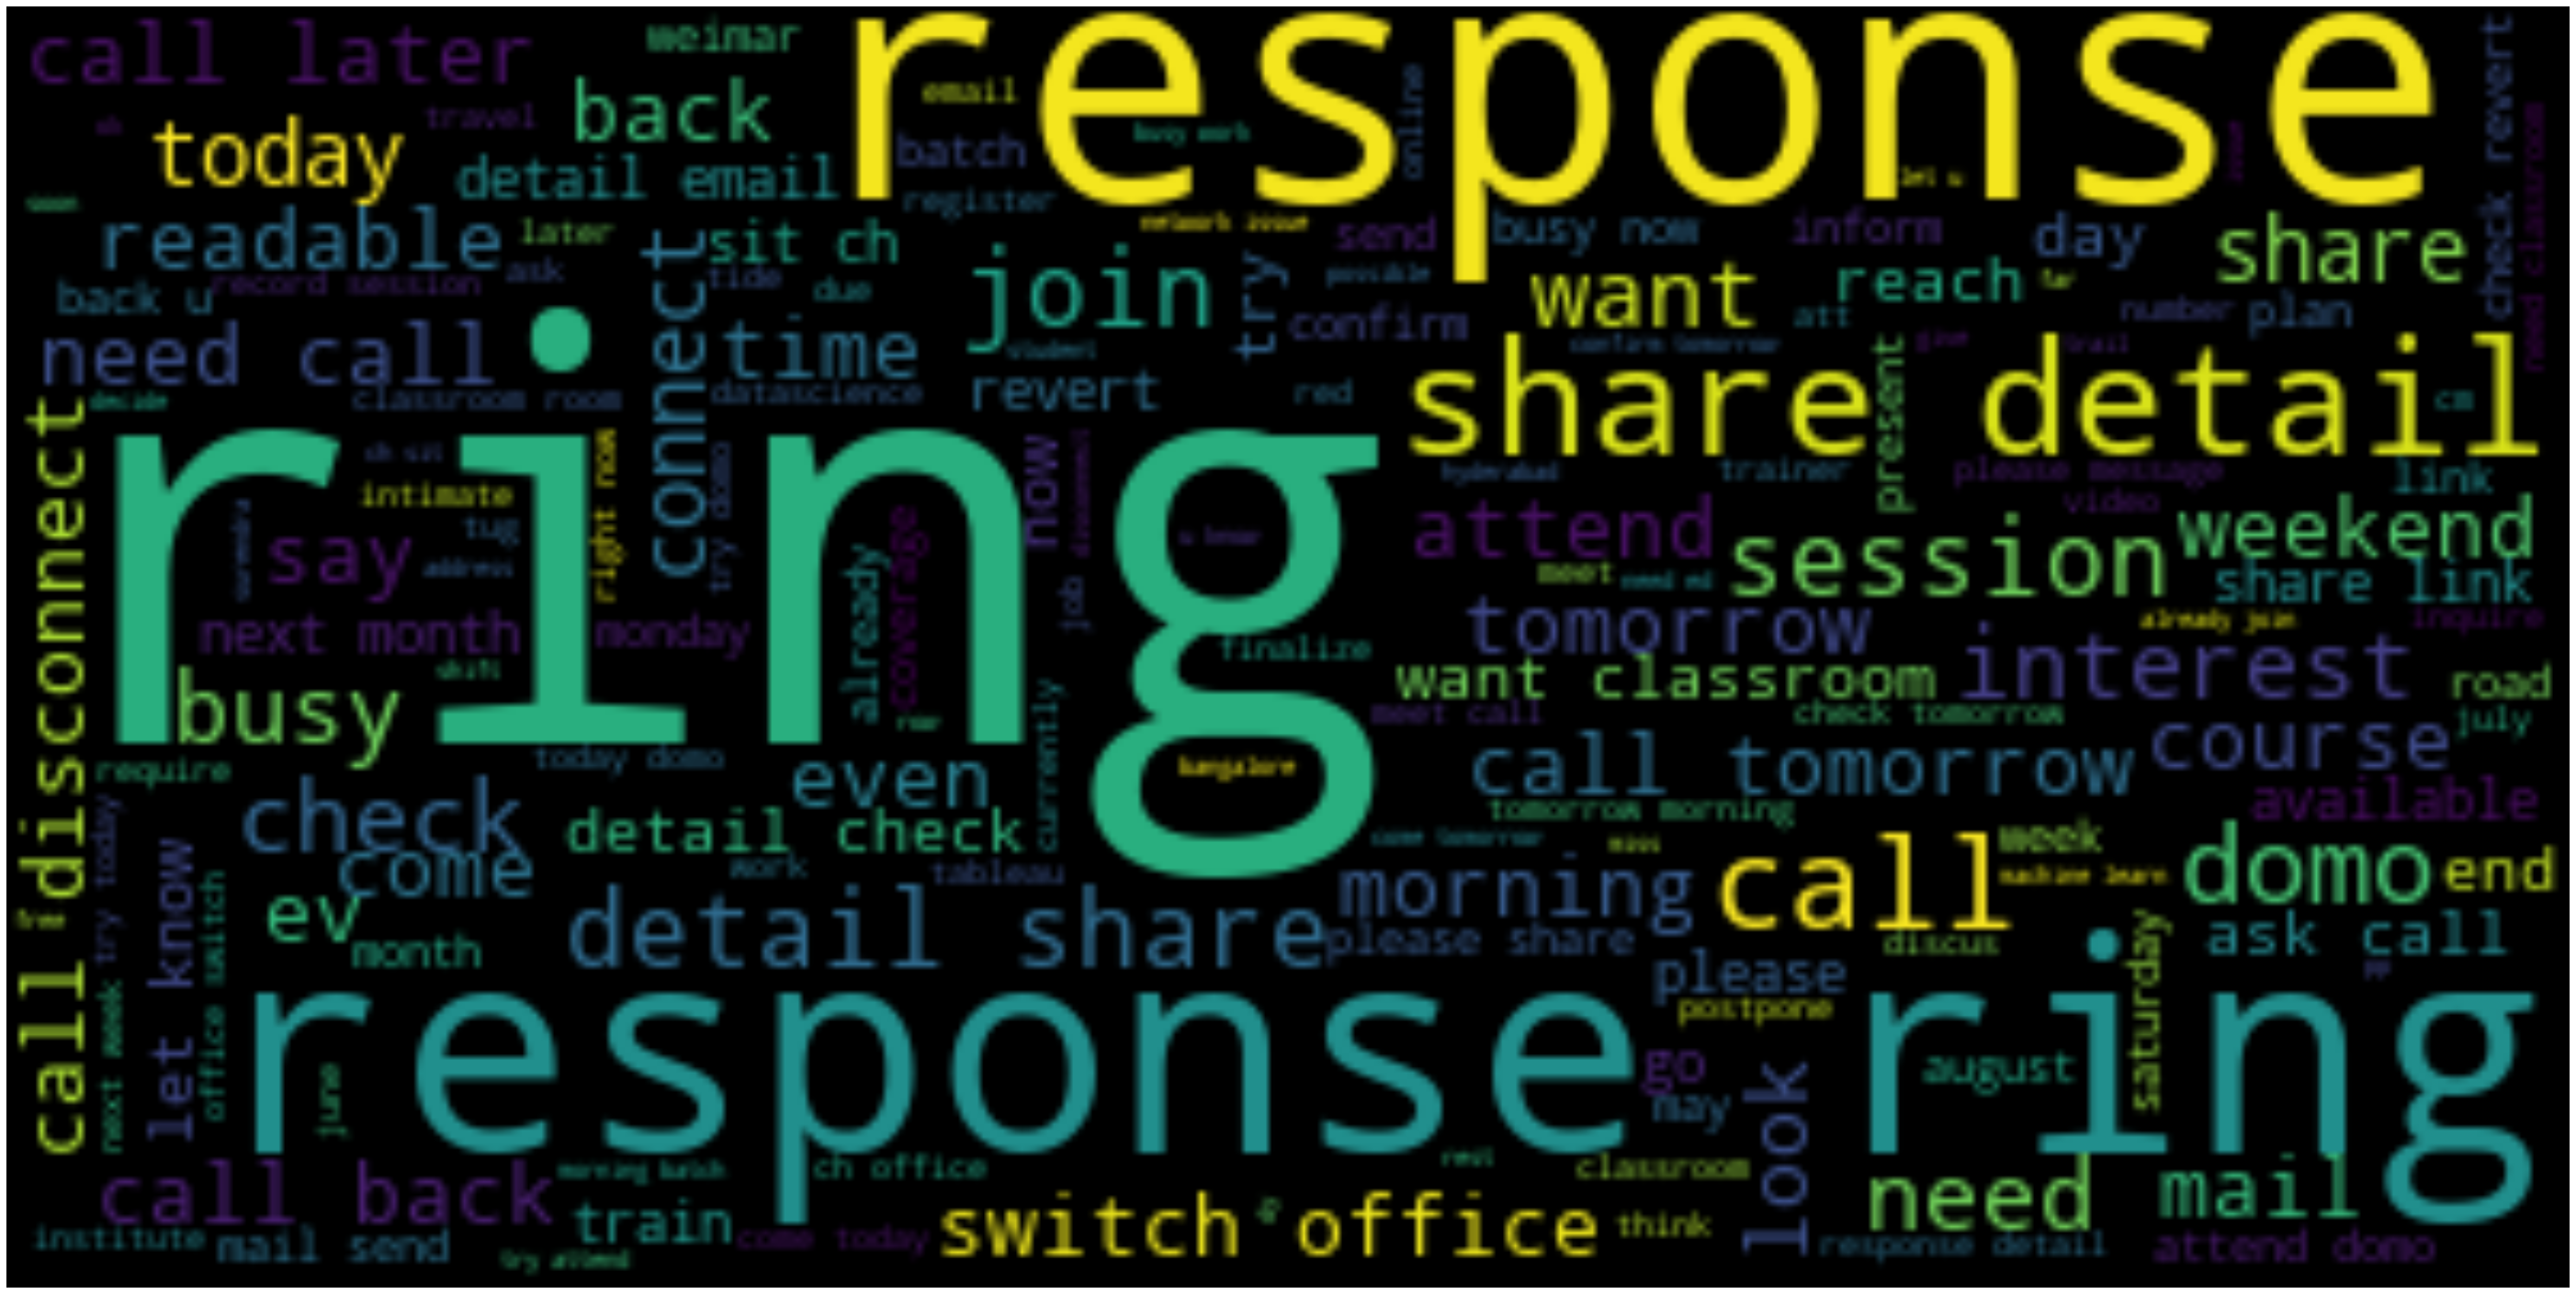

In [6]:
# Generate a word cloud image
text = " ".join(txt for txt in leads.cleaned_text)
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [81]:

#leads['Status'].unique()

In [13]:
leads['Status'].unique()

array(['not converted', 'converted'], dtype=object)

In [14]:
leads['Status'].value_counts()

not converted    829
converted        127
Name: Status, dtype: int64

In [15]:
leads_converted = leads.loc[leads['Status'] == 'converted']

In [16]:
leads_converted.head(5)

Lead Name   Location     Status  \
2       Sapna Dewani  bangalore  converted   
20        jana reddy  bangalore  converted   
30    Mohiuddin Khan  bangalore  converted   
38      Pooja TThuse  bangalore  converted   
41  Abhijit Garnayak  bangalore  converted   

                                   Status information  \
2                                    16|AuG|moHan:rnr   
20  8|aUg|moHan:intrstd 9|aUg|moHan:intrstd for ML...   
30  8|aUg|moHan:rnr 9|aUg|moHan:rnr 11|aUg|moHan:r...   
38  8/8/17(soma):Detaills Shared 9/8/17(soma):she ...   
41  8/8/17(Surendra):RNR 10/8/17(Surendra):RNR 16/...   

                                         cleaned_text  
2                                    ring no response  
20  machine learn morning call back other day call...  
30  ring no response ring no response ring no resp...  
38                        detail share say next month  
41  ring no response ring no response call check e...

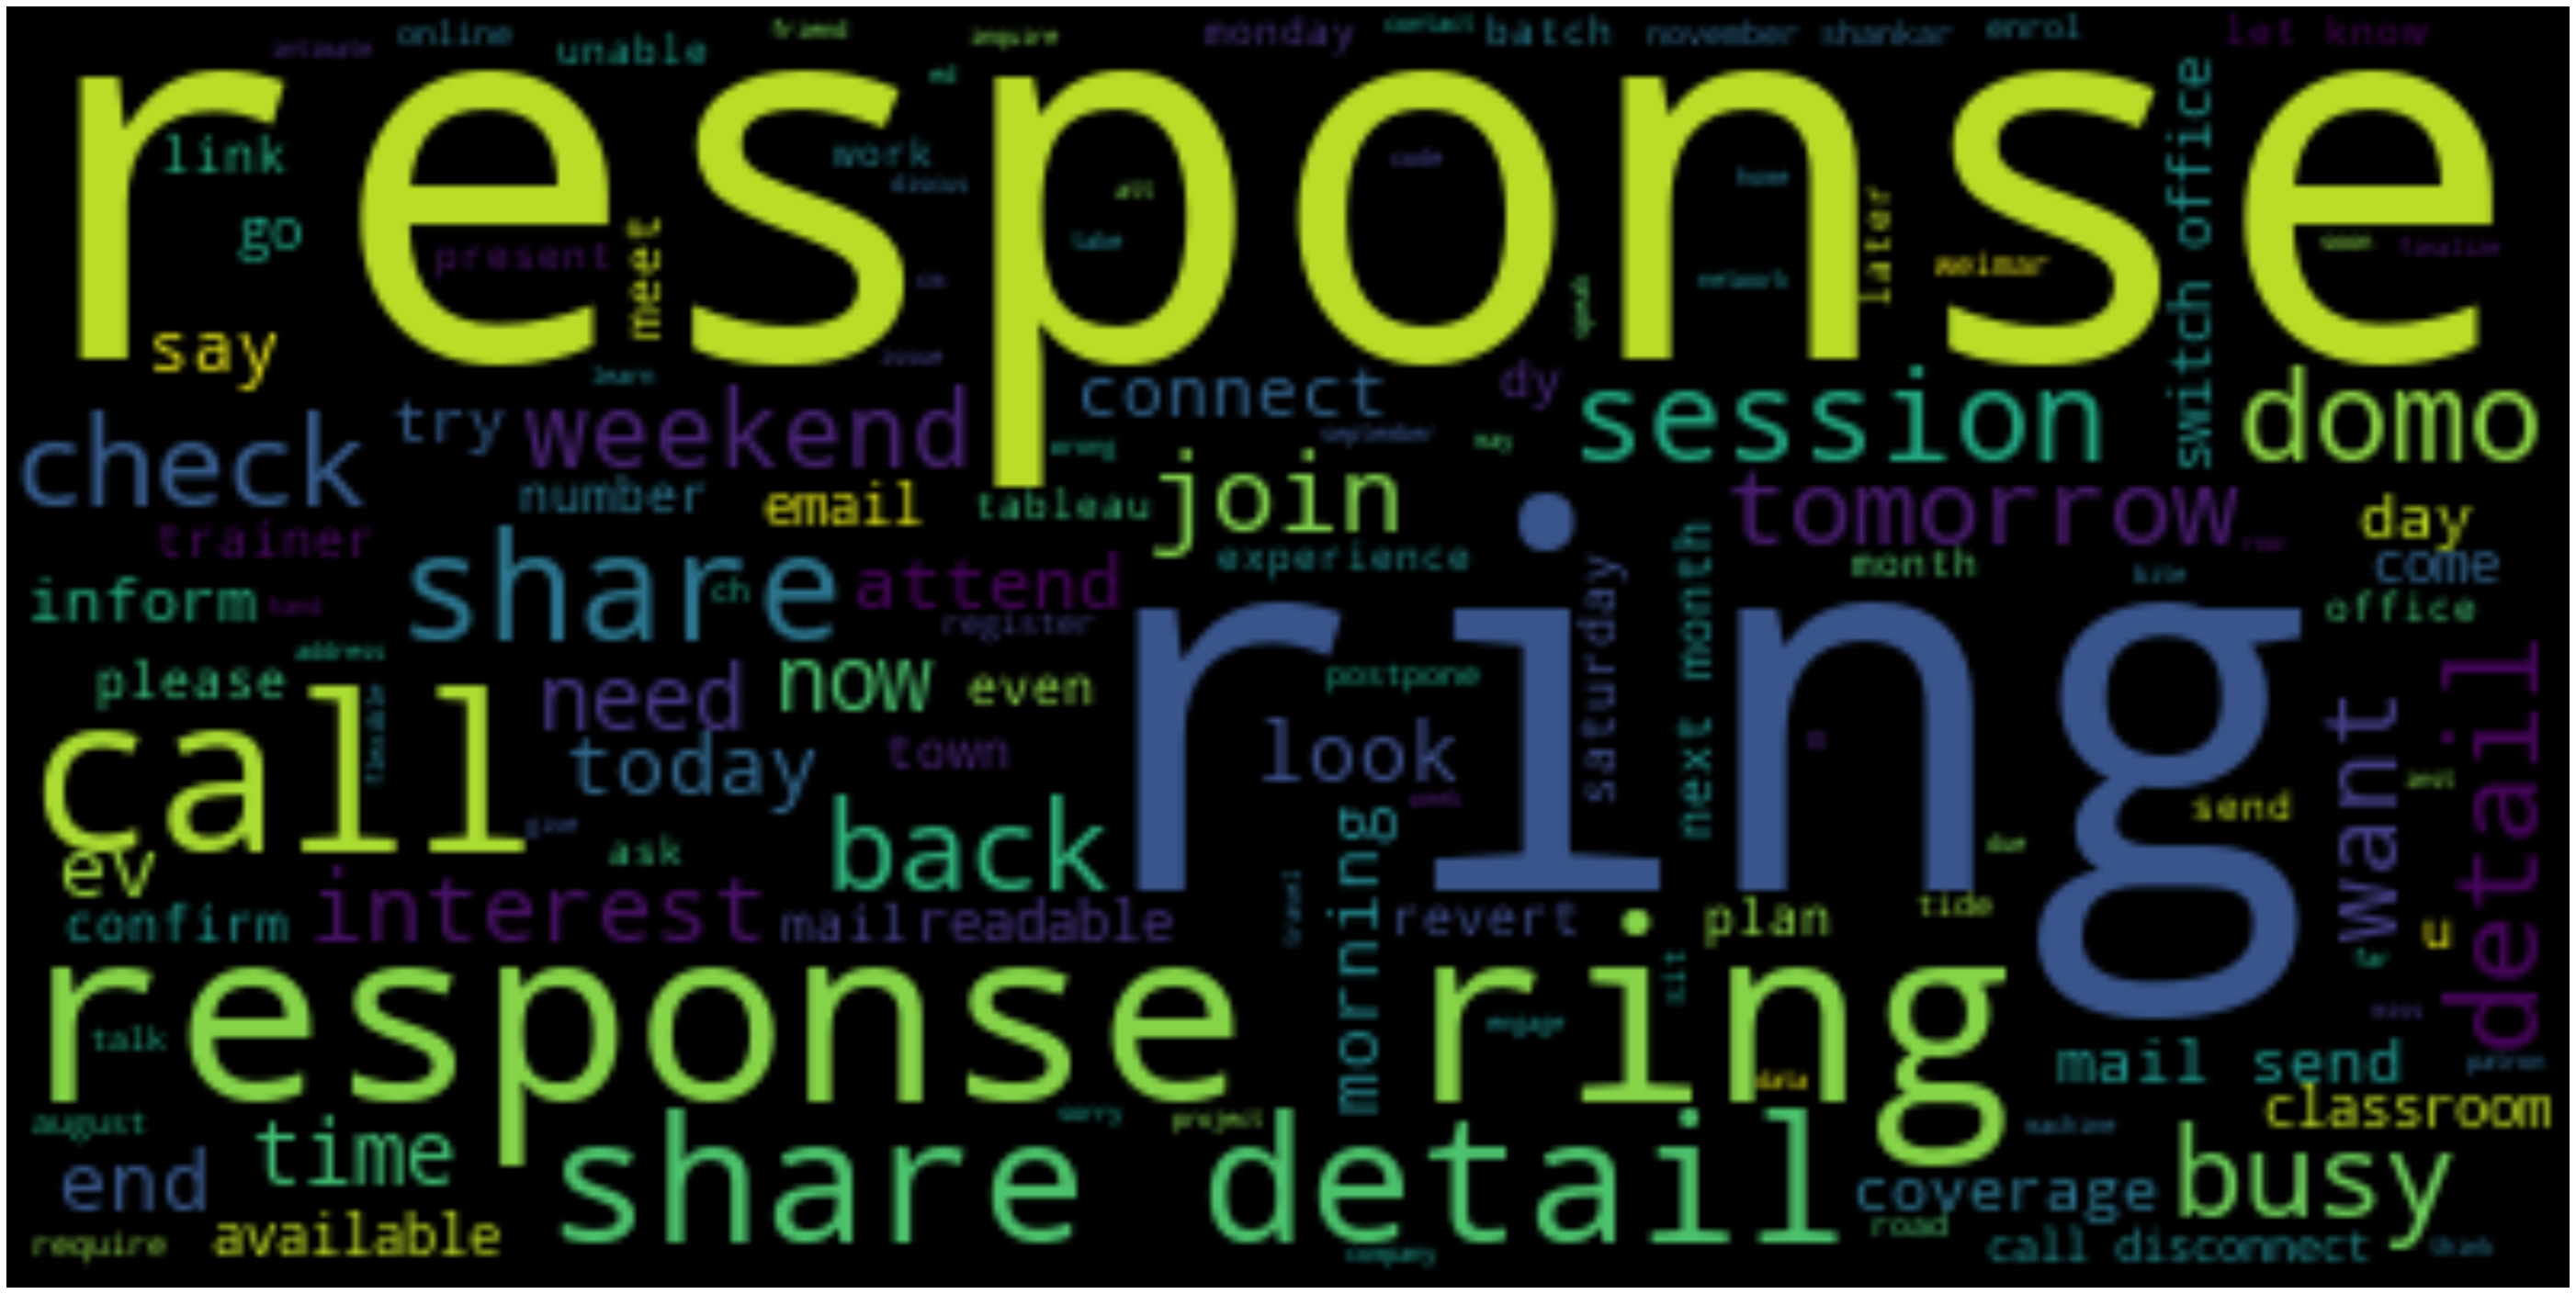

In [17]:
# Generate a word cloud image
text = " ".join(txt for txt in leads_converted.cleaned_text)
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<AxesSubplot:xlabel='Status', ylabel='count'>

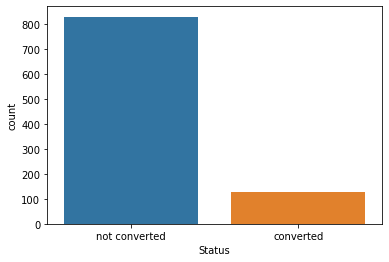

In [18]:
sns.countplot(x="Status",data=leads)

<AxesSubplot:xlabel='Location', ylabel='count'>

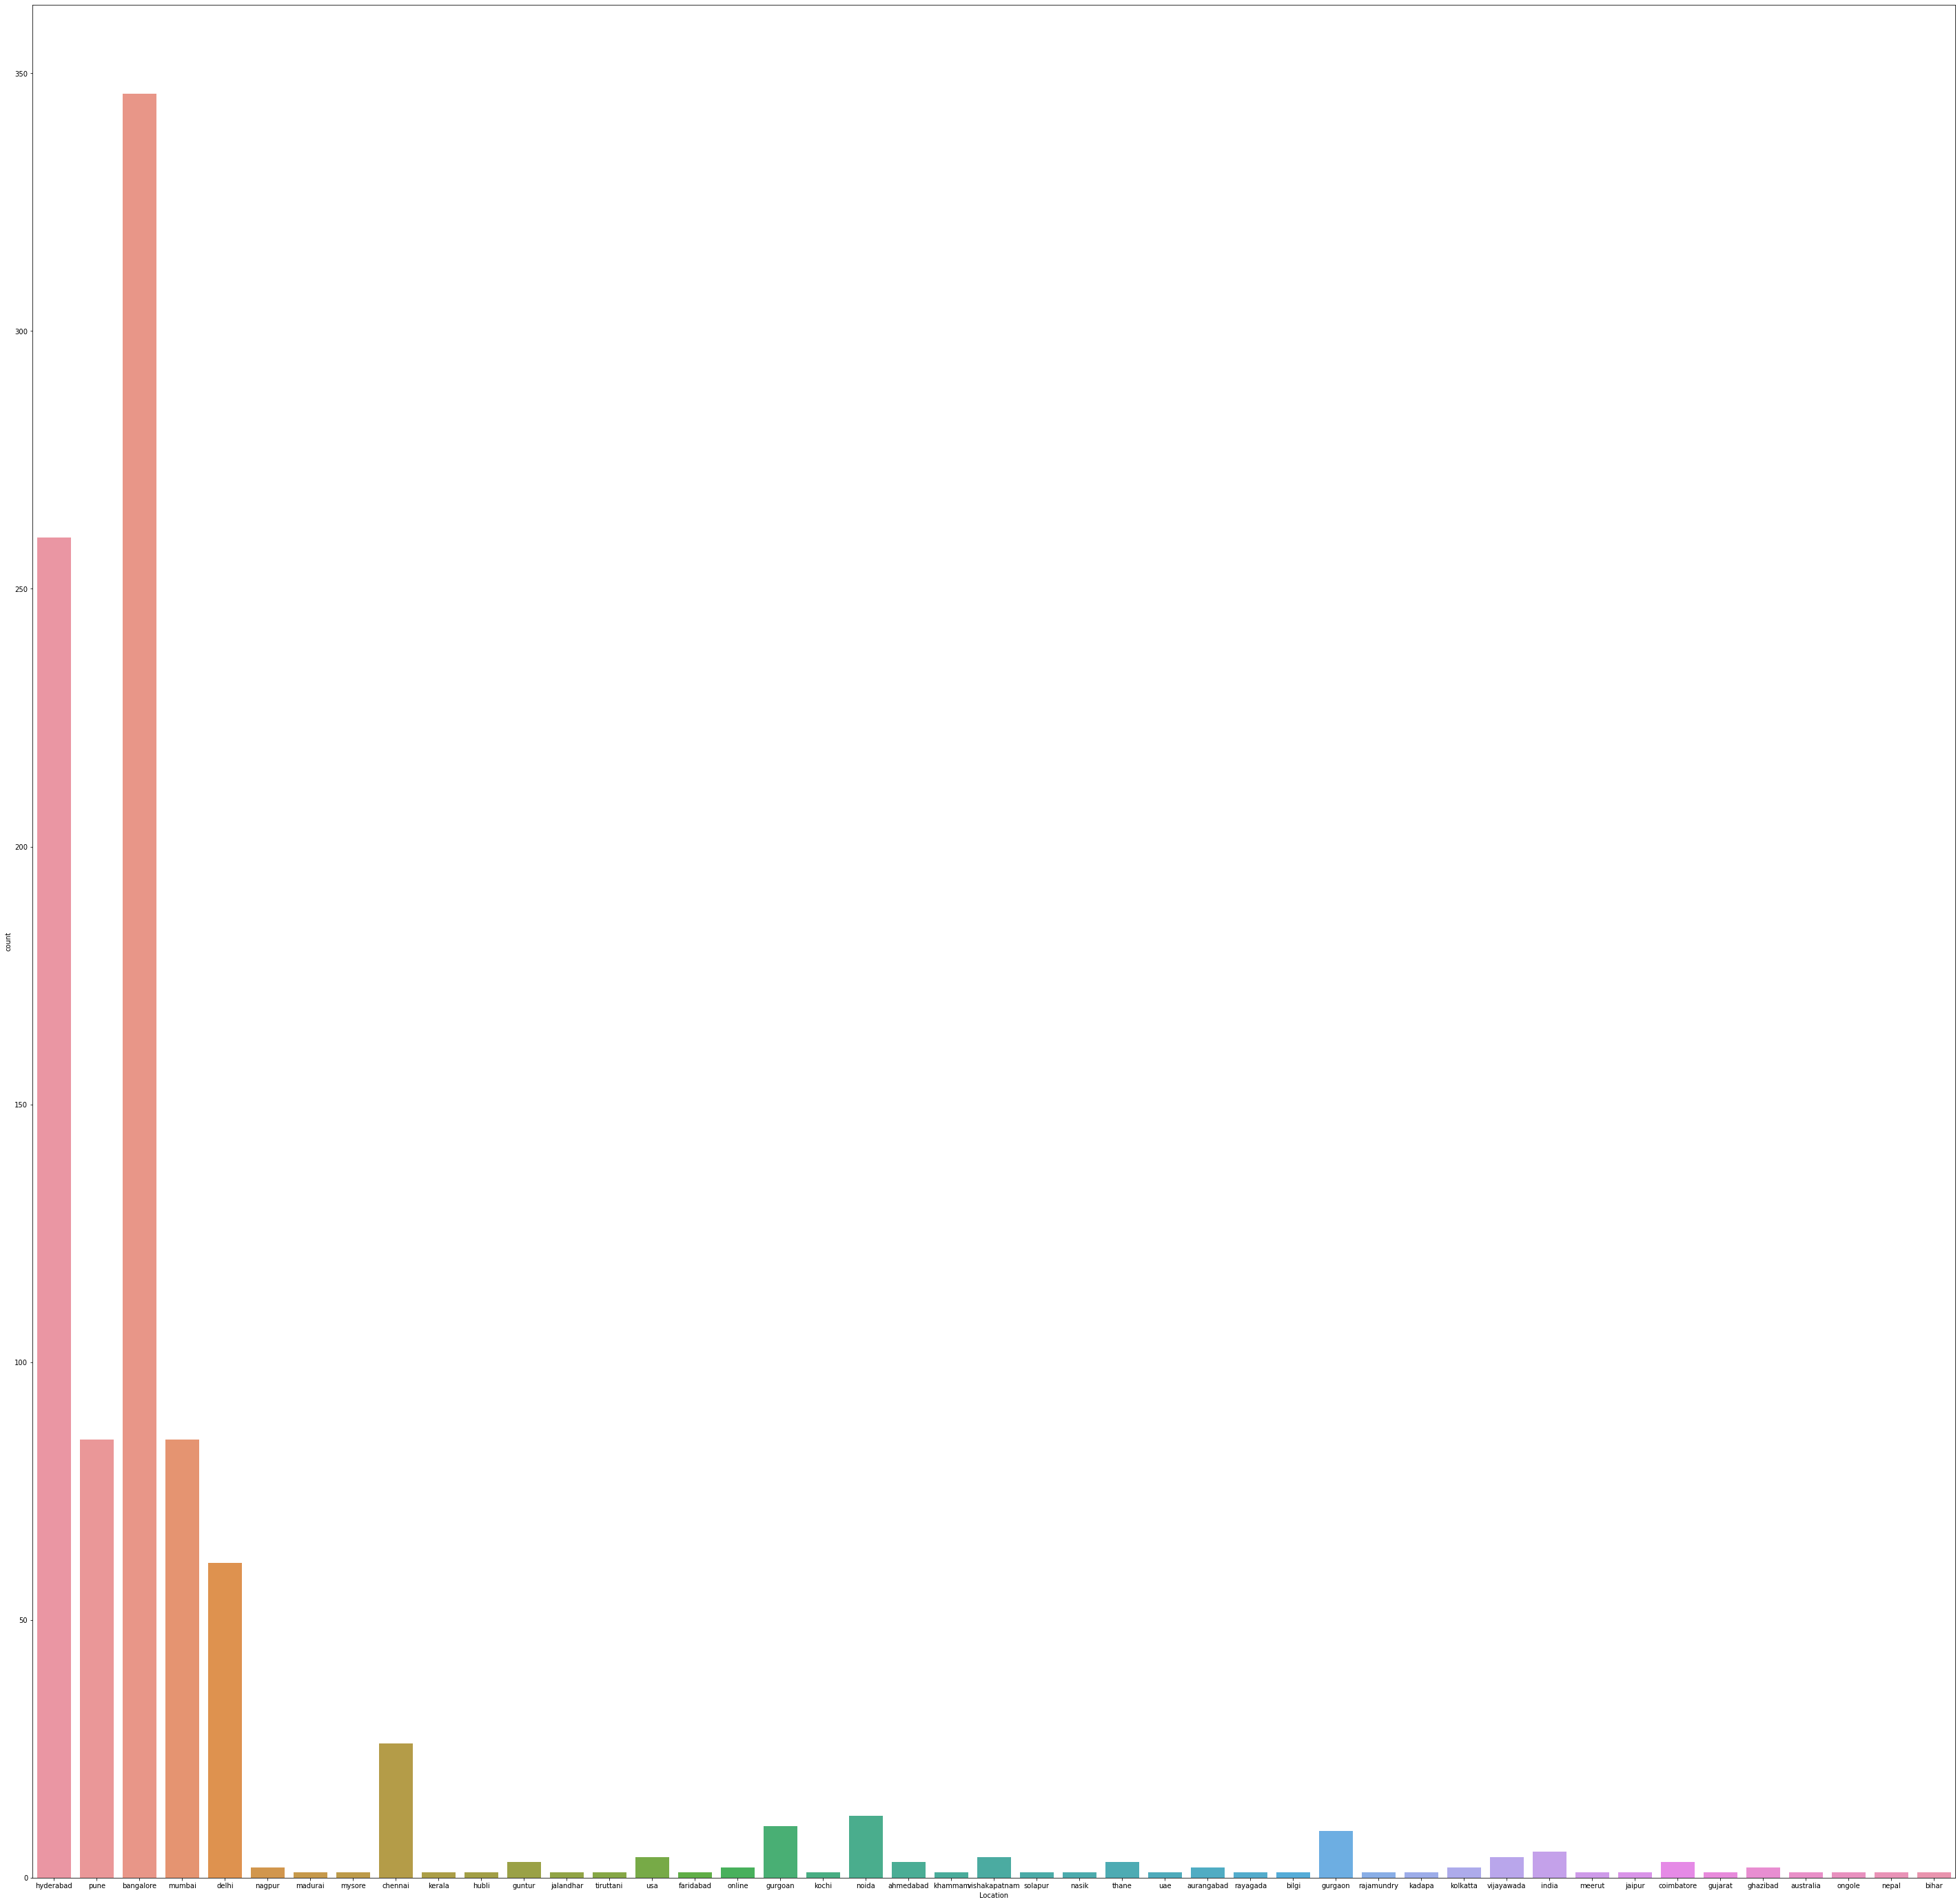

In [19]:
plt.figure(figsize=(50,50))
sns.countplot(x="Location",data=leads)

In [112]:
leads.reset_index(inplace = True, drop = True)

C:\Users\bhanu\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
save_file("final_cleaned",leads)

In [22]:
leads = load_file("lemmatize")

In [23]:
leads

Lead Name   Location        Status   \
0                    Raja  hyderabad  Not Converted   
1           Anirudh Reddy       pune  Not Converted   
2            Sapna Dewani  bangalore     Converted    
3                  suresh     mumbai  Not Converted   
4           Akshay Shinde  hyderabad  Not Converted   
...                   ...        ...            ...   
996                 vipin  bangalore  Not Converted   
997               dheeraj    chennai  Not Converted   
998         kuldeep singh  bangalore  Not Converted   
999          ankur sharma  bangalore  Not Converted   
1000  Saugata Chakrabarti  bangalore  Not Converted   

                                     Status information  \
0     14/8/prema: share me details, available in evn...   
1     14/8/prema: cal me tmrw, shared details to ema...   
2                                      16|AuG|moHan:rnr   
3     14/8/17(Surendra):i want only Server 16|AuG|mo...   
4     14/8/prema:rnr 16/8/prema: gave info, he said ...   
...                                                 ...   
996   25/4/17(Surendra):please send me details tomor...   
997   24/4/17(prema): need CT, but our venue is far....   
998   24/Apr/moHan:intrstd in evng batch trail perd ...   
999   1/5/17(Surendra):please share me details 11/5/...   
1000  24/4/17(prema): shared details need only Cert....   

                                           cleaned_text  
0     share detail available ev no postpone plan tra...  
1     call tomorrow share detail email share detail ...  
2                                      ring no response  
3                 want server call busy register server  
4     ring no response give say revert plan next mon...  
...                                                 ...  
996   please send detail tomorrow afternoon discus n...  
997   need venue far share detail datascience want v...  
998           ev no batch trail per dry register Excelr  
999                              please share detail do  
1000  share detail need certificate need call meet c...  

[956 rows x 5 columns]

## Task 1 : Based on customer status identify the topic whether the customer showing interest or not towards our product

The LDA topic model algorithm requires a document word matrix and a dictionary as the main inputs.

A document-term matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

A Dictionary is collection of all unique tokens present in documents.

In [24]:
def generate_tokens(text):
    words=[]
    for word in text.split(' '):
    # using the if condition because we introduced extra spaces during text cleaning
        if word!='':
            words.append(word)
    return words


In [25]:
#storing the generated tokens in a new column named 'token'
leads['tokens']=leads.cleaned_text.apply(generate_tokens)

In [26]:
leads['tokens']

0       [share, detail, available, ev, no, postpone, p...
1       [call, tomorrow, share, detail, email, share, ...
2                                    [ring, no, response]
3            [want, server, call, busy, register, server]
4       [ring, no, response, give, say, revert, plan, ...
                              ...                        
996     [please, send, detail, tomorrow, afternoon, di...
997     [need, venue, far, share, detail, datascience,...
998     [ev, no, batch, trail, per, dry, register, Exc...
999                           [please, share, detail, do]
1000    [share, detail, need, certificate, need, call,...
Name: tokens, Length: 956, dtype: object

### A Dictionary is collection of all unique tokens present in documents.

In [27]:
def create_dictionary(words):
    return corpora.Dictionary(words)

#passing the dataframe column having tokens as the argument
id2word=create_dictionary(leads.tokens)
print(id2word)

Dictionary(665 unique tokens: ['available', 'currently', 'detail', 'ev', 'interest']...)


### Create document matrix

In [28]:
def create_doc_term_matrix(tokens,id2word):
    corpus = []
    for text in tokens:
        corpus.append(id2word.doc2bow(text))
    return corpus

In [29]:
doc_matric = create_doc_term_matrix(leads.tokens,id2word)
print(leads.tokens[0])
print(doc_matric[0])

['share', 'detail', 'available', 'ev', 'no', 'postpone', 'plan', 'train', 'currently', 'not', 'interest', 'now']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]


## implementing lda topics

In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_matric,
                                            id2word=id2word,
                                            num_topics=3,
                                           random_state=100)

In [31]:
lda_model.print_topics(num_topics=2,num_words=5)

[(0,
  '0.104*"response" + 0.099*"no" + 0.084*"ring" + 0.060*"share" + 0.060*"detail"'),
 (2,
  '0.148*"ring" + 0.147*"no" + 0.125*"response" + 0.039*"not" + 0.031*"call"')]

## Generating LDA topics

In [32]:
def get_lda_topics(model,num_topics,top_n_words):
    word_dict={}
    for i in range(num_topics):
        word_dict['Topic # '+'{:02d}'.format(i+1)] = [i[0] for i in model.show_topic(i,topn=top_n_words)]
    return pd.DataFrame(word_dict)


In [33]:
get_lda_topics(lda_model,3,10)

Topic # 01 Topic # 02 Topic # 03
0   response      share       ring
1         no        not         no
2       ring       call   response
3      share     detail        not
4     detail       domo       call
5       call         no      share
6        not       need     detail
7      check       ring       busy
8       domo    session       want
9   tomorrow     office   interest

## Visualizing Topics

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,doc_matric,id2word,mds='mmds',R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.013983  0.015853       1        1  38.021042
2      0.061025 -0.005136       2        1  36.174544
1     -0.075009 -0.010717       3        1  25.804415, topic_info=        Term         Freq        Total Category  logprob  loglift
21      ring  1105.000000  1105.000000  Default  30.0000  30.0000
20  response  1079.000000  1079.000000  Default  29.0000  29.0000
5         no  1182.000000  1182.000000  Default  28.0000  28.0000
10     share   551.000000   551.000000  Default  27.0000  27.0000
2     detail   453.000000   453.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
19  tomorrow    33.628963   154.421234   Topic3  -4.5308  -0.1697
21      ring    72.691720  1105.451793   Topic3  -3.7599  -1.3672
20  response    56.146310  1079.080544   Topic3  -4.0182  -1.6013
64      join    29.539977   123.837834   Topic3  -4.6604  -0.0786
31      back    24.558454   123.796939   Topic3  -4.8451  -0.2630

[241 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
338       1  0.756659    Excelr
338       2  0.378330    Excelr
362       3  0.920140      able
188       1  0.879852    accept
589       2  0.500448  actually
...     ...       ...       ...
455       3  0.885754      wife
444       1  0.768809      will
140       1  0.832480     wrong
140       2  0.118926     wrong
140       3  0.118926     wrong

[373 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

## Keyword extraction using ngram TFIDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_hold = train_test_split(leads,test_size = 0.3,random_state=100)

In [23]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [38]:
#creating the vocabulary from the words
tfidf = TfidfVectorizer(ngram_range=(1,1))
corpus_doc = tfidf.fit_transform(X_train['cleaned_text']) 

In [39]:
corpus_doc.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
tfidf.get_feature_names()

C:\Users\bhanu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['able',
 'abroad',
 'accept',
 'accordingly',
 'act',
 'actually',
 'address',
 'admit',
 'afternoon',
 'afterward',
 'afterwards',
 'agency',
 'agenda',
 'aim',
 'already',
 'also',
 'analysis',
 'another',
 'apache',
 'appointment',
 'approach',
 'approval',
 'arrange',
 'arrive',
 'ask',
 'assistance',
 'att',
 'attend',
 'audible',
 'audit',
 'august',
 'australia',
 'auto',
 'avail',
 'available',
 'ave',
 'back',
 'bad',
 'baker',
 'bal',
 'bang',
 'bangalore',
 'bank',
 'base',
 'batch',
 'better',
 'big',
 'bitch',
 'bite',
 'block',
 'book',
 'br',
 'bring',
 'broadband',
 'brother',
 'brow',
 'business',
 'busy',
 'cab',
 'call',
 'camp',
 'canon',
 'cap',
 'car',
 'certificate',
 'ch',
 'chain',
 'change',
 'chat',
 'check',
 'cheek',
 'city',
 'clair',
 'class',
 'classroom',
 'clay',
 'clear',
 'client',
 'cm',
 'cod',
 'code',
 'college',
 'com',
 'come',
 'comfortable',
 'company',
 'compare',
 'complete',
 'con',
 'concern',
 'concession',
 'cond',
 'conduct',
 'cone',

In [24]:
from sklearn import decomposition

In [42]:
lda = decomposition.LatentDirichletAllocation(n_components = 3,max_iter =5,learning_method = 'online',learning_offset =50)

W1 = lda.fit_transform(corpus_doc)
H1 = lda.components_

In [43]:
W1

array([[0.08078446, 0.84046942, 0.07874612],
       [0.08741748, 0.82633844, 0.08624408],
       [0.06946741, 0.86362312, 0.06690946],
       ...,
       [0.09292094, 0.81454333, 0.09253573],
       [0.12728581, 0.18452069, 0.6881935 ],
       [0.11404212, 0.77075763, 0.11520024]])

In [44]:
## see topics
import numpy as np

num_words =2
vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t : [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = (top_words(t) for t in H1)
topics = [' '.join(t) for t in topic_words]

In [45]:
topics

['code ask', 'no ring', 'register numb']

# TASK2 : text classification with 2 features, location and status info

In [25]:
df_countVec = load_file("final_cleaned")

In [142]:
df_countVec['Status'] = df_countVec['Status'].replace('converted',1)
df_countVec['Status'] = df_countVec['Status'].replace('not converted',0)

In [322]:
save_file('final_dataframe',df_countVec)

In [26]:
df_countVec = load_file("final_dataframe")

In [27]:
df_countVec

Lead Name   Location  Status  \
0                    Raja  hyderabad       0   
1           Anirudh Reddy       pune       0   
2            Sapna Dewani  bangalore       1   
3                  suresh     mumbai       0   
4           Akshay Shinde  hyderabad       0   
...                   ...        ...     ...   
996                 vipin  bangalore       0   
997               dheeraj    chennai       0   
998         kuldeep singh  bangalore       0   
999          ankur sharma  bangalore       0   
1000  Saugata Chakrabarti  bangalore       0   

                                     Status information  \
0     14/8/prema: share me details, available in evn...   
1     14/8/prema: cal me tmrw, shared details to ema...   
2                                      16|AuG|moHan:rnr   
3     14/8/17(Surendra):i want only Server 16|AuG|mo...   
4     14/8/prema:rnr 16/8/prema: gave info, he said ...   
...                                                 ...   
996   25/4/17(Surendra):please send me details tomor...   
997   24/4/17(prema): need CT, but our venue is far....   
998   24/Apr/moHan:intrstd in evng batch trail perd ...   
999   1/5/17(Surendra):please share me details 11/5/...   
1000  24/4/17(prema): shared details need only Cert....   

                                           cleaned_text  \
0     share detail available ev no postpone plan tra...   
1     call tomorrow share detail email share detail ...   
2                                      ring no response   
3                 want server call busy register server   
4     ring no response give say revert plan next mon...   
...                                                 ...   
996   please send detail tomorrow afternoon discus n...   
997   need venue far share detail datascience want v...   
998           ev no batch trail per dry register Excelr   
999                              please share detail do   
1000  share detail need certificate need call meet c...   

                                          combined_text  
0     hyderabad share detail available ev no postpon...  
1     pune call tomorrow share detail email share de...  
2                            bangalore ring no response  
3          mumbai want server call busy register server  
4     hyderabad ring no response give say revert pla...  
...                                                 ...  
996   bangalore please send detail tomorrow afternoo...  
997   chennai need venue far share detail datascienc...  
998   bangalore ev no batch trail per dry register E...  
999                    bangalore please share detail do  
1000  bangalore share detail need certificate need c...  

[956 rows x 6 columns]

## Experiment 1 - Combaning text and location as one feature - countVectorizer

 - feature - = location + text
 
 - logisticREgression
 - Naive Bayes
 - SVC
 - Randomforest

In [144]:
## combine feature 
def combine_feature(f1,f2):
    text = f1+' '+ f2
    return text
    
    

In [145]:
df_countVec['combined_text'] = combine_feature(df_countVec['Location'],df_countVec['cleaned_text'])

In [146]:
df_countVec

Lead Name   Location  Status  \
0                    Raja  hyderabad       0   
1           Anirudh Reddy       pune       0   
2            Sapna Dewani  bangalore       1   
3                  suresh     mumbai       0   
4           Akshay Shinde  hyderabad       0   
...                   ...        ...     ...   
996                 vipin  bangalore       0   
997               dheeraj    chennai       0   
998         kuldeep singh  bangalore       0   
999          ankur sharma  bangalore       0   
1000  Saugata Chakrabarti  bangalore       0   

                                     Status information  \
0     14/8/prema: share me details, available in evn...   
1     14/8/prema: cal me tmrw, shared details to ema...   
2                                      16|AuG|moHan:rnr   
3     14/8/17(Surendra):i want only Server 16|AuG|mo...   
4     14/8/prema:rnr 16/8/prema: gave info, he said ...   
...                                                 ...   
996   25/4/17(Surendra):please send me details tomor...   
997   24/4/17(prema): need CT, but our venue is far....   
998   24/Apr/moHan:intrstd in evng batch trail perd ...   
999   1/5/17(Surendra):please share me details 11/5/...   
1000  24/4/17(prema): shared details need only Cert....   

                                           cleaned_text  \
0     share detail available ev no postpone plan tra...   
1     call tomorrow share detail email share detail ...   
2                                      ring no response   
3                 want server call busy register server   
4     ring no response give say revert plan next mon...   
...                                                 ...   
996   please send detail tomorrow afternoon discus n...   
997   need venue far share detail datascience want v...   
998           ev no batch trail per dry register Excelr   
999                              please share detail do   
1000  share detail need certificate need call meet c...   

                                          combined_text  
0     hyderabad share detail available ev no postpon...  
1     pune call tomorrow share detail email share de...  
2                            bangalore ring no response  
3          mumbai want server call busy register server  
4     hyderabad ring no response give say revert pla...  
...                                                 ...  
996   bangalore please send detail tomorrow afternoo...  
997   chennai need venue far share detail datascienc...  
998   bangalore ev no batch trail per dry register E...  
999                    bangalore please share detail do  
1000  bangalore share detail need certificate need c...  

[956 rows x 6 columns]

In [274]:
final_dataset = df_countVec[['combined_text','Status']]

In [275]:
final_dataset

combined_text  Status
0     hyderabad share detail available ev no postpon...       0
1     pune call tomorrow share detail email share de...       0
2                            bangalore ring no response       1
3          mumbai want server call busy register server       0
4     hyderabad ring no response give say revert pla...       0
...                                                 ...     ...
996   bangalore please send detail tomorrow afternoo...       0
997   chennai need venue far share detail datascienc...       0
998   bangalore ev no batch trail per dry register E...       0
999                    bangalore please share detail do       0
1000  bangalore share detail need certificate need c...       0

[956 rows x 2 columns]

In [277]:
cntVec = CountVectorizer()
X = final_dataset.combined_text
y = final_dataset.Status

In [278]:
y.shape

(956,)

In [279]:
cntV = cntVec.fit(X)
df_X = pd.DataFrame(cntV.transform(X).todense(),columns=cntV.get_feature_names_out())

In [280]:
df_X.shape


(956, 702)

In [281]:
oversample = SMOTE()
X, y = oversample.fit_resample(df_X, y)
X.shape , y.shape

((1658, 702), (1658,))

In [282]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)

In [283]:
X_train.shape,X_test.shape ,y_train.shape

((1326, 702), (332, 702), (1326,))

In [271]:
# # applu countvec
# cntV = cntVec.fit(X_train)
# df_train = pd.DataFrame(cntV.transform(X_train).todense(),columns=cntV.get_feature_names_out())
# df_test = pd.DataFrame(cntV.transform(X_test).todense(),columns=cntV.get_feature_names_out())

In [285]:
X_train

able  abroad  accept  accordingly  act  action  actually  address  \
43       0       0       0            0    0       0         0        0   
711      0       0       0            0    0       0         0        0   
1555     0       0       0            0    0       0         0        0   
1046     0       0       0            0    0       0         0        0   
1634     0       0       0            0    0       0         0        0   
...    ...     ...     ...          ...  ...     ...       ...      ...   
53       0       0       0            0    0       0         0        0   
350      0       0       0            0    0       0         0        0   
79       0       0       0            0    0       0         0        0   
792      0       0       0            0    0       0         0        0   
1544     0       0       0            0    0       0         0        0   

      admit  advance  ...  well  whether  wife  will  within  work  would  \
43        0        0  ...     0        0     0     0       0     0      0   
711       0        0  ...     1        0     0     0       0     0      0   
1555      0        0  ...     0        0     0     0       0     0      0   
1046      0        0  ...     0        0     0     0       0     0      0   
1634      0        0  ...     0        0     0     0       0     0      0   
...     ...      ...  ...   ...      ...   ...   ...     ...   ...    ...   
53        0        0  ...     0        0     0     0       0     0      0   
350       0        0  ...     0        0     0     0       0     0      0   
79        0        0  ...     0        0     0     0       0     1      0   
792       0        0  ...     0        0     0     0       0     0      0   
1544      0        0  ...     0        0     0     0       0     0      0   

      wrong  yesterday  yet  
43        0          0    0  
711       0          0    0  
1555      0          0    0  
1046      0          0    0  
1634      0          0    0  
...     ...        ...  ...  
53        0          0    0  
350       0          0    0  
79        0          0    0  
792       0          0    0  
1544      0          0    0  

[1326 rows x 702 columns]

### Logistic Regression

In [286]:
lr = LogisticRegression(class_weight={0:0.5, 1:0.5})
lr.fit(X_train,y_train)

LogisticRegression(class_weight={0: 0.5, 1: 0.5})

In [287]:
print("test Acc", lr.score(X_test,y_test))
print("train Acc", lr.score(X_train,y_train))
y_pred = lr.predict(X_train)
pred_test = lr.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.8343373493975904
train Acc 0.8657616892911011
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       612
           1       0.90      0.84      0.87       714

    accuracy                           0.87      1326
   macro avg       0.87      0.87      0.87      1326
weighted avg       0.87      0.87      0.87      1326



In [288]:
confusion_matrix(y_test, pred_test)

array([[132,  37],
       [ 18, 145]], dtype=int64)

### Naive Bayes

In [289]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

In [290]:
print("test Acc", nb.score(X_test,y_test))
print("train Acc", nb.score(X_train,y_train))
y_pred = nb.predict(X_train)
pred_test = nb.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.7439759036144579
train Acc 0.7805429864253394
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       651
           1       0.79      0.78      0.78       675

    accuracy                           0.78      1326
   macro avg       0.78      0.78      0.78      1326
weighted avg       0.78      0.78      0.78      1326



In [291]:
confusion_matrix(y_test, pred_test)

array([[120,  49],
       [ 36, 127]], dtype=int64)

## SVC

In [292]:
svc = SVC(class_weight='balanced')
svc.fit(X_train,y_train)

SVC(class_weight='balanced')

In [293]:
print("test Acc", svc.score(X_test,y_test))
print("train Acc", svc.score(X_train,y_train))
y_pred = svc.predict(X_train)
pred_test = svc.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.8433734939759037
train Acc 0.8808446455505279
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       604
           1       0.92      0.85      0.89       722

    accuracy                           0.88      1326
   macro avg       0.88      0.88      0.88      1326
weighted avg       0.88      0.88      0.88      1326



In [294]:
confusion_matrix(y_test, pred_test)

array([[132,  37],
       [ 15, 148]], dtype=int64)

## RandomForest

In [295]:
rf = RandomForestClassifier(n_estimators=500,class_weight='balanced')
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500)

In [296]:
print("test Acc", rf.score(X_test,y_test))
print("train Acc", rf.score(X_train,y_train))
y_pred = rf.predict(X_train)
pred_test = rf.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.8704819277108434
train Acc 0.9856711915535445
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       645
           1       1.00      0.98      0.99       681

    accuracy                           0.99      1326
   macro avg       0.99      0.99      0.99      1326
weighted avg       0.99      0.99      0.99      1326



In [297]:
confusion_matrix(y_test, pred_test)

array([[144,  25],
       [ 18, 145]], dtype=int64)

In [307]:
# define model
model = RandomForestClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.930


In [317]:
n_estimators = [500, 800, 1200]
max_depth = [25, 30]
min_samples_split = [10, 15]
min_samples_leaf = [5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

#forest = RandomForestClassifier(random_state = 1)

gridF = GridSearchCV(rf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [318]:
print("test Acc", bestF.score(X_test,y_test))
print("train Acc", bestF.score(X_train,y_train))
y_pred = bestF.predict(X_train)
pred_test = bestF.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.8102409638554217
train Acc 0.8265460030165912
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       584
           1       0.88      0.79      0.84       742

    accuracy                           0.83      1326
   macro avg       0.83      0.83      0.83      1326
weighted avg       0.83      0.83      0.83      1326



In [319]:
confusion_matrix(y_test, pred_test)

array([[125,  44],
       [ 19, 144]], dtype=int64)

In [320]:
save_file('cntRandomGS.pickle',bestF)

In [227]:
y.value_counts()

0    829
1    829
Name: Status, dtype: int64

In [309]:
from xgboost import XGBClassifier

In [311]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train,y_train)

[18:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [312]:
print("test Acc", xgb.score(X_test,y_test))
print("train Acc", xgb.score(X_train,y_train))
y_pred = xgb.predict(X_train)
pred_test = xgb.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.8734939759036144
train Acc 0.9502262443438914
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       628
           1       0.97      0.93      0.95       698

    accuracy                           0.95      1326
   macro avg       0.95      0.95      0.95      1326
weighted avg       0.95      0.95      0.95      1326



In [313]:
confusion_matrix(y_test, pred_test)

array([[143,  26],
       [ 16, 147]], dtype=int64)

## Experiement 2 - Tfidf Vectorizers

In [18]:
df_countVec = load_file("final_dataframe")

# convert location to one hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')
loc_ohe = pd.DataFrame(ohe.fit_transform(df_countVec[['Location']]).toarray(),columns=ohe.get_feature_names_out())
loc_ohe

Location_ahmedabad  Location_aurangabad  Location_australia  \
0                   0.0                  0.0                 0.0   
1                   0.0                  0.0                 0.0   
2                   0.0                  0.0                 0.0   
3                   0.0                  0.0                 0.0   
4                   0.0                  0.0                 0.0   
..                  ...                  ...                 ...   
951                 0.0                  0.0                 0.0   
952                 0.0                  0.0                 0.0   
953                 0.0                  0.0                 0.0   
954                 0.0                  0.0                 0.0   
955                 0.0                  0.0                 0.0   

     Location_bangalore  Location_bihar  Location_bilgi  Location_chennai  \
0                   0.0             0.0             0.0               0.0   
1                   0.0             0.0             0.0               0.0   
2                   1.0             0.0             0.0               0.0   
3                   0.0             0.0             0.0               0.0   
4                   0.0             0.0             0.0               0.0   
..                  ...             ...             ...               ...   
951                 1.0             0.0             0.0               0.0   
952                 0.0             0.0             0.0               1.0   
953                 1.0             0.0             0.0               0.0   
954                 1.0             0.0             0.0               0.0   
955                 1.0             0.0             0.0               0.0   

     Location_coimbatore  Location_delhi  Location_faridabad  ...  \
0                    0.0             0.0                 0.0  ...   
1                    0.0             0.0                 0.0  ...   
2                    0.0             0.0                 0.0  ...   
3                    0.0             0.0                 0.0  ...   
4                    0.0             0.0                 0.0  ...   
..                   ...             ...                 ...  ...   
951                  0.0             0.0                 0.0  ...   
952                  0.0             0.0                 0.0  ...   
953                  0.0             0.0                 0.0  ...   
954                  0.0             0.0                 0.0  ...   
955                  0.0             0.0                 0.0  ...   

     Location_pune  Location_rajamundry  Location_rayagada  Location_solapur  \
0              0.0                  0.0                0.0               0.0   
1              1.0                  0.0                0.0               0.0   
2              0.0                  0.0                0.0               0.0   
3              0.0                  0.0                0.0               0.0   
4              0.0                  0.0                0.0               0.0   
..             ...                  ...                ...               ...   
951            0.0                  0.0                0.0               0.0   
952            0.0                  0.0                0.0               0.0   
953            0.0                  0.0                0.0               0.0   
954            0.0                  0.0                0.0               0.0   
955            0.0                  0.0                0.0               0.0   

     Location_thane  Location_tiruttani  Location_uae  Location_usa  \
0               0.0                 0.0           0.0           0.0   
1               0.0                 0.0           0.0           0.0   
2               0.0                 0.0           0.0           0.0   
3               0.0                 0.0           0.0           0.0   
4               0.0                 0.0           0.0           0.0   
..              ...                 ...        

In [19]:
save_file('onehotencoder',ohe)

In [20]:
## Create tfidf data for text column

In [21]:
tfidfVec = TfidfVectorizer(ngram_range=(1,1),max_df=0.9)
text_col = df_countVec.cleaned_text
df_text_tfidf = pd.DataFrame(tfidfVec.fit_transform(text_col).todense(),columns=tfidfVec.get_feature_names_out())
df_text_tfidf

able  abroad  accept  accordingly  act  action  actually  address  admit  \
0     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
1     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
2     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
3     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
4     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
..    ...     ...     ...          ...  ...     ...       ...      ...    ...   
951   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
952   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
953   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
954   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
955   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   

     advance  ...  well  whether  wife  will  within  work  would  wrong  \
0        0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   
1        0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   
2        0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   
3        0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   
4        0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   
..       ...  ...   ...      ...   ...   ...     ...   ...    ...    ...   
951      0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   
952      0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   
953      0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   
954      0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   
955      0.0  ...   0.0      0.0   0.0   0.0     0.0   0.0    0.0    0.0   

     yesterday  yet  
0          0.0  0.0  
1          0.0  0.0  
2          0.0  0.0  
3          0.0  0.0  
4          0.0  0.0  
..         ...  ...  
951        0.0  0.0  
952        0.0  0.0  
953        0.0  0.0  
954        0.0  0.0  
955        0.0  0.0  

[956 rows x 662 columns]

In [53]:

save_file('tfidfVec',tfidfVec)


In [22]:
##cancate tow dataframe
df_status = df_countVec[['Status']].reset_index(drop=True)
df_CMR = pd.concat((df_text_tfidf,loc_ohe,df_status),axis=1)
df_CMR = df_CMR.reset_index(drop=True)
df_CMR

able  abroad  accept  accordingly  act  action  actually  address  admit  \
0     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
1     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
2     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
3     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
4     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
..    ...     ...     ...          ...  ...     ...       ...      ...    ...   
951   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
952   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
953   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
954   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   
955   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   

     advance  ...  Location_rajamundry  Location_rayagada  Location_solapur  \
0        0.0  ...                  0.0                0.0               0.0   
1        0.0  ...                  0.0                0.0               0.0   
2        0.0  ...                  0.0                0.0               0.0   
3        0.0  ...                  0.0                0.0               0.0   
4        0.0  ...                  0.0                0.0               0.0   
..       ...  ...                  ...                ...               ...   
951      0.0  ...                  0.0                0.0               0.0   
952      0.0  ...                  0.0                0.0               0.0   
953      0.0  ...                  0.0                0.0               0.0   
954      0.0  ...                  0.0                0.0               0.0   
955      0.0  ...                  0.0                0.0               0.0   

     Location_thane  Location_tiruttani  Location_uae  Location_usa  \
0               0.0                 0.0           0.0           0.0   
1               0.0                 0.0           0.0           0.0   
2               0.0                 0.0           0.0           0.0   
3               0.0                 0.0           0.0           0.0   
4               0.0                 0.0           0.0           0.0   
..              ...                 ...           ...           ...   
951             0.0                 0.0           0.0           0.0   
952             0.0                 0.0           0.0           0.0   
953             0.0                 0.0           0.0           0.0   
954             0.0                 0.0           0.0           0.0   
955             0.0                 0.0           0.0           0.0   

     Location_vijayawada  Location_vishakapatnam  Status  
0                    0.0                     0.0       0  
1                    0.0                     0.0       0  
2                    0.0                     0.0       1  
3                    0.0                     0.0       0  
4                    0.0                     0.0       0  
..                   ...                     ...     ...  
951                  0.0                     0.0       0  
952                  0.0                     0.0       0  
953                  0.0                     0.0       0  
954                  0.0                     0.0       0  
955                  0.0                     0.0       0  

[956 rows x 708 columns]

In [23]:
## oversamle data
X = df_CMR.drop(columns=['Status'])
y = df_CMR['Status']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X.shape , y.shape

((1658, 707), (1658,))

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=100)

In [25]:
X_train.shape,X_test.shape ,y_train.shape

((1326, 707), (332, 707), (1326,))

In [26]:
X_train

able  abroad  accept  accordingly  act  action  actually  address  \
82     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   
457    0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   
1471   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   
1542   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   
979    0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   
...    ...     ...     ...          ...  ...     ...       ...      ...   
1620   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   
96     0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   
475    0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   
1111   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   
199    0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0   

      admit  advance  ...  Location_pune  Location_rajamundry  \
82      0.0      0.0  ...            0.0                  0.0   
457     0.0      0.0  ...            0.0                  0.0   
1471    0.0      0.0  ...            0.0                  0.0   
1542    0.0      0.0  ...            0.0                  0.0   
979     0.0      0.0  ...            0.0                  0.0   
...     ...      ...  ...            ...                  ...   
1620    0.0      0.0  ...            0.0                  0.0   
96      0.0      0.0  ...            0.0                  0.0   
475     0.0      0.0  ...            0.0                  0.0   
1111    0.0      0.0  ...            1.0                  0.0   
199     0.0      0.0  ...            0.0                  0.0   

      Location_rayagada  Location_solapur  Location_thane  Location_tiruttani  \
82                  0.0               0.0             0.0                 0.0   
457                 0.0               0.0             0.0                 0.0   
1471                0.0               0.0             0.0                 0.0   
1542                0.0               0.0             0.0                 0.0   
979                 0.0               0.0             0.0                 0.0   
...                 ...               ...             ...                 ...   
1620                0.0               0.0             0.0                 0.0   
96                  0.0               0.0             0.0                 0.0   
475                 0.0               0.0             0.0                 0.0   
1111                0.0               0.0             0.0                 0.0   
199                 0.0               0.0             0.0                 0.0   

      Location_uae  Location_usa  Location_vijayawada  Location_vishakapatnam  
82             0.0           0.0                  0.0                     0.0  
457            0.0           0.0                  0.0                     0.0  
1471           0.0           0.0                  0.0                     0.0  
1542           0.0           0.0                  0.0                     0.0  
979            0.0           0.0                  0.0                     0.0  
...            ...           ...                  ...                     ...  
1620           0.0           0.0                  0.0                     0.0  
96             0.0           0.0                  0.0                     0.0  
475            0.0           0.0                  0.0                     0.0  
1111           0.0           0.0                  0.0                     0.0  
199            0.0           0.0                  0.0                     0.0  

[1326 rows x 707 columns]

### Logistic Regression

In [27]:
lr_tfidf = LogisticRegression(class_weight={0:0.5, 1:0.5})
lr_tfidf.fit(X_train,y_train)

LogisticRegression(class_weight={0: 0.5, 1: 0.5})

In [28]:
print("test Acc", lr_tfidf.score(X_test,y_test))
print("train Acc", lr_tfidf.score(X_train,y_train))
y_pred = lr_tfidf.predict(X_train)
pred_test = lr_tfidf.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.7319277108433735
train Acc 0.782051282051282
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       628
           1       0.81      0.77      0.79       698

    accuracy                           0.78      1326
   macro avg       0.78      0.78      0.78      1326
weighted avg       0.78      0.78      0.78      1326



In [29]:
confusion_matrix(y_test, pred_test)

array([[113,  53],
       [ 36, 130]], dtype=int64)

### Naive Bayes

In [30]:
nb_tfidf = MultinomialNB() # for binary classification
nb_tfidf.fit(X_train,y_train)

MultinomialNB()

In [31]:
print("test Acc", nb_tfidf.score(X_test,y_test))
print("train Acc", nb_tfidf.score(X_train,y_train))
y_pred = nb_tfidf.predict(X_train)
pred_test = nb_tfidf.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.7620481927710844
train Acc 0.8024132730015083
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       519
           1       0.91      0.75      0.82       807

    accuracy                           0.80      1326
   macro avg       0.80      0.82      0.80      1326
weighted avg       0.83      0.80      0.80      1326



In [32]:
confusion_matrix(y_test, pred_test)

array([[ 98,  68],
       [ 11, 155]], dtype=int64)

## SVC

In [33]:
svc_tfidf = SVC(class_weight='balanced')
svc_tfidf.fit(X_train,y_train)

SVC(class_weight='balanced')

In [34]:
print("test Acc", svc_tfidf.score(X_test,y_test))
print("train Acc", svc_tfidf.score(X_train,y_train))
y_pred = svc_tfidf.predict(X_train)
pred_test = svc_tfidf.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.9156626506024096
train Acc 0.951734539969834
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       631
           1       0.98      0.93      0.95       695

    accuracy                           0.95      1326
   macro avg       0.95      0.95      0.95      1326
weighted avg       0.95      0.95      0.95      1326



In [35]:
confusion_matrix(y_test, pred_test)

array([[148,  18],
       [ 10, 156]], dtype=int64)

In [36]:
kernels = ['linear', 'rbf', 'poly']
gammas = [0.1, 1, 10, 100]
cs = [0.1, 1, 10, 100, 200]
degrees = [0, 1, 2, 3, 4, 5, 6]

for kernel in kernels:
    svc = SVC(kernel=kernel).fit(X_train, y_train)
    print("test Acc", svc.score(X_test,y_test))
    print("train Acc", svc.score(X_train,y_train))
    y_pred = svc.predict(X_train)
    pred_test = svc.predict(X_test)
    print(classification_report(y_pred,y_train))
    print(confusion_matrix(y_test, pred_test))

test Acc 0.7710843373493976
train Acc 0.8318250377073907
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       564
           1       0.91      0.79      0.84       762

    accuracy                           0.83      1326
   macro avg       0.83      0.84      0.83      1326
weighted avg       0.84      0.83      0.83      1326

[[106  60]
 [ 16 150]]
test Acc 0.9156626506024096
train Acc 0.951734539969834
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       631
           1       0.98      0.93      0.95       695

    accuracy                           0.95      1326
   macro avg       0.95      0.95      0.95      1326
weighted avg       0.95      0.95      0.95      1326

[[148  18]
 [ 10 156]]
test Acc 0.9126506024096386
train Acc 0.9487179487179487
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       629
           1       0.

In [37]:
svc_tfidf = SVC(kernel = 'rbf')
svc_tfidf.fit(X_train,y_train)

SVC()

In [38]:
print("test Acc", svc_tfidf.score(X_test,y_test))
print("train Acc", svc_tfidf.score(X_train,y_train))
y_pred = svc_tfidf.predict(X_train)
pred_test = svc_tfidf.predict(X_test)
print(classification_report(y_pred,y_train))
print(confusion_matrix(y_test, pred_test))

test Acc 0.9156626506024096
train Acc 0.951734539969834
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       631
           1       0.98      0.93      0.95       695

    accuracy                           0.95      1326
   macro avg       0.95      0.95      0.95      1326
weighted avg       0.95      0.95      0.95      1326

[[148  18]
 [ 10 156]]


In [39]:
save_file("svc_tfidf.pickle",svc_tfidf)

In [40]:
model_svc = SVC()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_svc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.962


In [41]:
kernels = ['linear', 'rbf', 'poly']
gammas = [0.1, 1, 10, 100]
cs = [0.1, 1, 10]
degrees = [0, 1, 2, 3, 4]

In [42]:
hyperF = dict(kernel = kernels, gamma = gammas,  
              C = cs, degree = degrees)

#forest = RandomForestClassifier(random_state = 1)

gridF = GridSearchCV(model_svc, hyperF, cv = 3, verbose = 2, 
                      n_jobs = 1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] END ..........C=0.1, degree=0, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ..........C=0.1, degree=0, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ..........C=0.1, degree=0, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END .............C=0.1, degree=0, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .............C=0.1, degree=0, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END .............C=0.1, degree=0, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END ............C=0.1, degree=0, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ............C=0.1, degree=0, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ............C=0.1, degree=0, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ............C=0.1, degree=0, gamma=1, kernel=linear; total time=   0.2s
[CV] END ............C=0.1, degree=0, gamma=1, kernel=linear; total time=   0.2s
[CV] END ............C=0.1, degree=0, gamma=1,

[CV] END ..........C=0.1, degree=2, gamma=100, kernel=linear; total time=   0.2s
[CV] END .............C=0.1, degree=2, gamma=100, kernel=rbf; total time=   0.3s
[CV] END .............C=0.1, degree=2, gamma=100, kernel=rbf; total time=   0.3s
[CV] END .............C=0.1, degree=2, gamma=100, kernel=rbf; total time=   0.3s
[CV] END ............C=0.1, degree=2, gamma=100, kernel=poly; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=100, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=2, gamma=100, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END .............C=0.1, degree=3, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .............C=0.1, degree=3, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .............C=0.1,

[CV] END ................C=1, degree=0, gamma=10, kernel=rbf; total time=   0.3s
[CV] END ...............C=1, degree=0, gamma=10, kernel=poly; total time=   0.2s
[CV] END ...............C=1, degree=0, gamma=10, kernel=poly; total time=   0.1s
[CV] END ...............C=1, degree=0, gamma=10, kernel=poly; total time=   0.2s
[CV] END ............C=1, degree=0, gamma=100, kernel=linear; total time=   0.1s
[CV] END ............C=1, degree=0, gamma=100, kernel=linear; total time=   0.1s
[CV] END ............C=1, degree=0, gamma=100, kernel=linear; total time=   0.1s
[CV] END ...............C=1, degree=0, gamma=100, kernel=rbf; total time=   0.4s
[CV] END ...............C=1, degree=0, gamma=100, kernel=rbf; total time=   0.3s
[CV] END ...............C=1, degree=0, gamma=100, kernel=rbf; total time=   0.3s
[CV] END ..............C=1, degree=0, gamma=100, kernel=poly; total time=   0.2s
[CV] END ..............C=1, degree=0, gamma=100, kernel=poly; total time=   0.2s
[CV] END ..............C=1, 

[CV] END ................C=1, degree=3, gamma=1, kernel=poly; total time=   0.2s
[CV] END .............C=1, degree=3, gamma=10, kernel=linear; total time=   0.1s
[CV] END .............C=1, degree=3, gamma=10, kernel=linear; total time=   0.1s
[CV] END .............C=1, degree=3, gamma=10, kernel=linear; total time=   0.1s
[CV] END ................C=1, degree=3, gamma=10, kernel=rbf; total time=   0.3s
[CV] END ................C=1, degree=3, gamma=10, kernel=rbf; total time=   0.4s
[CV] END ................C=1, degree=3, gamma=10, kernel=rbf; total time=   0.3s
[CV] END ...............C=1, degree=3, gamma=10, kernel=poly; total time=   0.2s
[CV] END ...............C=1, degree=3, gamma=10, kernel=poly; total time=   0.2s
[CV] END ...............C=1, degree=3, gamma=10, kernel=poly; total time=   0.1s
[CV] END ............C=1, degree=3, gamma=100, kernel=linear; total time=   0.1s
[CV] END ............C=1, degree=3, gamma=100, kernel=linear; total time=   0.1s
[CV] END ............C=1, de

[CV] END .............C=10, degree=1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ................C=10, degree=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ................C=10, degree=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ................C=10, degree=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ...............C=10, degree=1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ...............C=10, degree=1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ...............C=10, degree=1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ............C=10, degree=1, gamma=10, kernel=linear; total time=   0.1s
[CV] END ............C=10, degree=1, gamma=10, kernel=linear; total time=   0.2s
[CV] END ............C=10, degree=1, gamma=10, kernel=linear; total time=   0.1s
[CV] END ...............C=10, degree=1, gamma=10, kernel=rbf; total time=   0.3s
[CV] END ...............C=10, degree=1, gamma=10, kernel=rbf; total time=   0.3s
[CV] END ...............C=10

[CV] END ..............C=10, degree=4, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .............C=10, degree=4, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END .............C=10, degree=4, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END .............C=10, degree=4, gamma=0.1, kernel=poly; total time=   0.3s
[CV] END .............C=10, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV] END .............C=10, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV] END .............C=10, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV] END ................C=10, degree=4, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ................C=10, degree=4, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ................C=10, degree=4, gamma=1, kernel=rbf; total time=   0.3s
[CV] END ...............C=10, degree=4, gamma=1, kernel=poly; total time=   0.3s
[CV] END ...............C=10, degree=4, gamma=1, kernel=poly; total time=   0.1s
[CV] END ...............C=10

In [43]:
print("test Acc", bestF.score(X_test,y_test))
print("train Acc", bestF.score(X_train,y_train))
y_pred = bestF.predict(X_train)
pred_test = bestF.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.9487951807228916
train Acc 0.9826546003016591
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       642
           1       1.00      0.97      0.98       684

    accuracy                           0.98      1326
   macro avg       0.98      0.98      0.98      1326
weighted avg       0.98      0.98      0.98      1326



In [44]:
confusion_matrix(y_test, pred_test)

array([[153,  13],
       [  4, 162]], dtype=int64)

In [46]:
save_file("svc_tfidfGS.pickle",bestF)

## PRediction

In [48]:
svc_model = load_file("svc_tfidfGS.pickle")

In [51]:
text = '23/MaY/moHan:attnde demo 23/MaY/moHan:he want in june today check and will make token payment 30/MaY/moHan:he will research and do token payment 7/JunE/moHan:he will check tmng nd respnd in 5dys 13/JunE/moHan:buay with work some othr time 13/JulY/moHan: call me mndy 2|AuG|moHan:i will try'
loc = 'pune'

In [52]:
## preprocess data
text = data_cleaning(text)
text

'att domo want june today check make token payment research token payment check tm no rest work other time call dy try'

In [61]:
## create DTM with tfidf for text data
tfidfVec = load_file("tfidfVec")
df_text_tfidf = pd.DataFrame(tfidfVec.transform([text]).todense(),columns=tfidfVec.get_feature_names_out())
df_text_tfidf

able  abroad  accept  accordingly  act  action  actually  address  admit  \
0   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   

   advance  ...  well  whether  wife  will  within      work  would  wrong  \
0      0.0  ...   0.0      0.0   0.0   0.0     0.0  0.178844    0.0    0.0   

   yesterday  yet  
0        0.0  0.0  

[1 rows x 662 columns]

In [66]:
## create one hot encoding data for location
ohe = load_file('onehotencoder')
loc_ohe = pd.DataFrame(ohe.transform([[loc]]).toarray(),columns=ohe.get_feature_names_out())
loc_ohe

Location_ahmedabad  Location_aurangabad  Location_australia  \
0                 0.0                  0.0                 0.0   

   Location_bangalore  Location_bihar  Location_bilgi  Location_chennai  \
0                 0.0             0.0             0.0               0.0   

   Location_coimbatore  Location_delhi  Location_faridabad  ...  \
0                  0.0             0.0                 0.0  ...   

   Location_pune  Location_rajamundry  Location_rayagada  Location_solapur  \
0            1.0                  0.0                0.0               0.0   

   Location_thane  Location_tiruttani  Location_uae  Location_usa  \
0             0.0                 0.0           0.0           0.0   

   Location_vijayawada  Location_vishakapatnam  
0                  0.0                     0.0  

[1 rows x 45 columns]

In [67]:
## cancatenate features
df_test_pred = pd.concat((df_text_tfidf,loc_ohe),axis=1)
df_test_pred

able  abroad  accept  accordingly  act  action  actually  address  admit  \
0   0.0     0.0     0.0          0.0  0.0     0.0       0.0      0.0    0.0   

   advance  ...  Location_pune  Location_rajamundry  Location_rayagada  \
0      0.0  ...            1.0                  0.0                0.0   

   Location_solapur  Location_thane  Location_tiruttani  Location_uae  \
0               0.0             0.0                 0.0           0.0   

   Location_usa  Location_vijayawada  Location_vishakapatnam  
0           0.0                  0.0                     0.0  

[1 rows x 707 columns]

In [73]:
result = svc_model.predict(df_test_pred)
result[0]

0

In [75]:
if result[0] == 0:
    prediction = "Lead will not convert"
else:
    prediction = "Lead will convert"
prediction

'Lead will not convert'

In [49]:
svc_model.predict(['test'])

C:\Users\bhanu\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


ValueError: could not convert string to float: 'test'

## Random Forest

In [589]:
rf_tfidf = RandomForestClassifier(n_estimators=100)
rf_tfidf.fit(X_train,y_train)

RandomForestClassifier()

In [590]:
print("test Acc", rf_tfidf.score(X_test,y_test))
print("train Acc", rf_tfidf.score(X_train,y_train))
y_pred = rf_tfidf.predict(X_train)
pred_test = rf_tfidf.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.927710843373494
train Acc 0.9924585218702866
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       663
           1       0.99      0.99      0.99       663

    accuracy                           0.99      1326
   macro avg       0.99      0.99      0.99      1326
weighted avg       0.99      0.99      0.99      1326



In [591]:
confusion_matrix(y_test, pred_test)

array([[158,   8],
       [ 16, 150]], dtype=int64)

In [592]:

save_file('rf_tfidf.pickle',rf_tfidf)
save_file('tfidfVec.pickle',tfidfVec)

In [594]:
### Cross vaidation

In [593]:
# define model
model = RandomForestClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.955


In [595]:
n_estimators = [200,500, 800, 1000, 1200]
max_depth = [25, 30, 35]
min_samples_split = [10, 15, 20]
min_samples_leaf = [5, 10, 15] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

#forest = RandomForestClassifier(random_state = 1)

gridF = GridSearchCV(rf_tfidf, hyperF, cv = 3, verbose = 2, 
                      n_jobs = 1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   1.6s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   1.2s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   1.1s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   2.0s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   1.8s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   1.6s
[CV] END max_depth=

[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_estimators=500; total time=   0.9s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_estimators=800; total time=   1.5s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_estimators=800; total time=   1.4s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_estimators=800; total time=   1.4s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_estimators=1000; total time=   2.0s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_estimators=1000; total time=   1.9s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_estimators=1000; total time=   1.9s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_estimators=1200; total time=   2.3s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_estimators=1200; total time=   2.3s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=20, n_

[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=15, n_estimators=1000; total time=   2.1s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=15, n_estimators=1000; total time=   2.1s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=15, n_estimators=1200; total time=   2.4s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=15, n_estimators=1200; total time=   2.5s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=15, n_estimators=1200; total time=   2.5s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=20, n_estimators=500; total time=   1.0s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=20, n_estimators

[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estimators=500; total time=   0.7s
[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estimators=500; total time=   0.7s
[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estimators=500; total time=   0.8s
[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estimators=800; total time=   1.3s
[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estimators=800; total time=   1.3s
[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estimators=800; total time=   1.3s
[CV] END max_depth=30, min_samples_leaf=15, min_samples_split=15, n_estim

[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   1.4s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   1.4s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   1.3s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=   1.8s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; total time=   2.1s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; total time=   2.0s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=10, n_

[CV] END max_depth=35, min_samples_leaf=15, min_samples_split=20, n_estimators=1000; total time=   1.6s
[CV] END max_depth=35, min_samples_leaf=15, min_samples_split=20, n_estimators=1000; total time=   1.5s
[CV] END max_depth=35, min_samples_leaf=15, min_samples_split=20, n_estimators=1200; total time=   2.0s
[CV] END max_depth=35, min_samples_leaf=15, min_samples_split=20, n_estimators=1200; total time=   1.9s
[CV] END max_depth=35, min_samples_leaf=15, min_samples_split=20, n_estimators=1200; total time=   1.9s


In [598]:
save_file('TfidfGridGS.pickle',bestF)

In [596]:
print("test Acc", bestF.score(X_test,y_test))
print("train Acc", bestF.score(X_train,y_train))
y_pred = bestF.predict(X_train)
pred_test = bestF.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.8012048192771084
train Acc 0.8868778280542986
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       743
           1       0.83      0.94      0.88       583

    accuracy                           0.89      1326
   macro avg       0.89      0.89      0.89      1326
weighted avg       0.89      0.89      0.89      1326



In [597]:
confusion_matrix(y_test, pred_test)

array([[149,  17],
       [ 49, 117]], dtype=int64)

In [600]:
n_estimators = [800, 1000, 1200]
max_depth = [35,45]
min_samples_split = [20,30]
min_samples_leaf = [10, 15,25] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

#forest = RandomForestClassifier(random_state = 1)

gridF1 = GridSearchCV(rf_tfidf, hyperF, cv = 5, verbose = 2, 
                      n_jobs = 1)
bestF1 = gridF1.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=20, n_estimators=800; total time=   1.8s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=20, n_estimators=800; total time=   1.8s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=20, n_estimators=800; total time=   1.6s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=20, n_estimators=800; total time=   1.6s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=20, n_estimators=800; total time=   1.6s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=20, n_estimators=1000; total time=   2.2s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=20, n_estimators=1000; total time=   2.0s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=20, n_estimators=1000; total time=   2.1s
[CV] END max_depth=35, min_samples_leaf=10, min_samples_split=20, n_estimators=1000; total time=   2.3s
[CV] EN

[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30, n_estimators=800; total time=   1.4s
[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30, n_estimators=1000; total time=   1.7s
[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30, n_estimators=1000; total time=   1.6s
[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30, n_estimators=1000; total time=   1.7s
[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30, n_estimators=1000; total time=   1.7s
[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30, n_estimators=1000; total time=   1.7s
[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30, n_estimators=1200; total time=   2.0s
[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30, n_estimators=1200; total time=   2.0s
[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30, n_estimators=1200; total time=   2.2s
[CV] END max_depth=35, min_samples_leaf=25, min_samples_split=30,

[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=20, n_estimators=1000; total time=   1.6s
[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=20, n_estimators=1200; total time=   1.9s
[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=20, n_estimators=1200; total time=   1.9s
[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=20, n_estimators=1200; total time=   2.0s
[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=20, n_estimators=1200; total time=   2.1s
[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=20, n_estimators=1200; total time=   2.0s
[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=30, n_estimators=800; total time=   1.4s
[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=30, n_estimators=800; total time=   1.3s
[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=30, n_estimators=800; total time=   1.2s
[CV] END max_depth=45, min_samples_leaf=25, min_samples_split=30, n

In [601]:
print("test Acc", bestF1.score(X_test,y_test))
print("train Acc", bestF1.score(X_train,y_train))
y_pred = bestF1.predict(X_train)
pred_test = bestF1.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.7740963855421686
train Acc 0.8393665158371041
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       730
           1       0.79      0.88      0.83       596

    accuracy                           0.84      1326
   macro avg       0.84      0.84      0.84      1326
weighted avg       0.84      0.84      0.84      1326



In [602]:
save_file('TfidfGridGS_2.pickle',bestF1)

In [603]:
confusion_matrix(y_test, pred_test)

array([[140,  26],
       [ 49, 117]], dtype=int64)

## XGBoost

In [428]:
xgb_tfidf = XGBClassifier()
xgb_tfidf.fit(X_train,y_train)

[00:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [393]:
print("test Acc", xgb_tfidf.score(X_test,y_test))
print("train Acc", xgb_tfidf.score(X_train,y_train))
y_pred = xgb_tfidf.predict(X_train)
pred_test = xgb_tfidf.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.8493975903614458
train Acc 0.978129713423831
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       660
           1       0.98      0.98      0.98       666

    accuracy                           0.98      1326
   macro avg       0.98      0.98      0.98      1326
weighted avg       0.98      0.98      0.98      1326



In [394]:
confusion_matrix(y_test, pred_test)

array([[141,  25],
       [ 25, 141]], dtype=int64)

In [426]:
y_train

82      0
457     1
1471    1
1542    1
979     1
       ..
1620    1
96      0
475     0
1111    1
199     0
Name: Status, Length: 1326, dtype: int64

In [430]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 use_label_encoder=False,
 seed=27)
xgb1.fit( X_train,y_train)



[00:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [432]:
print("test Acc", xgb1.score(X_test,y_test))
print("train Acc", xgb1.score(X_train,y_train))
y_pred = xgb1.predict(X_train)
pred_test = xgb1.predict(X_test)
print(classification_report(y_pred,y_train))

test Acc 0.8403614457831325
train Acc 0.9819004524886877
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       667
           1       0.98      0.98      0.98       659

    accuracy                           0.98      1326
   macro avg       0.98      0.98      0.98      1326
weighted avg       0.98      0.98      0.98      1326



In [463]:
confusion_matrix(y_test, pred_test)

array([[145,  21],
       [ 11, 155]], dtype=int64)